In [1]:
library(dplyr)
library(readr)
install.packages("caret")
library(caret)
install.packages("ggplot2")
library(ggplot2)
install.packages("randomForest")
library(randomForest)
library(lubridate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggpl

In [2]:

# Instalar y cargar las bibliotecas necesarias
install.packages("googledrive")
library(googledrive)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Autenticarse con Google Drive
drive_auth()

Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=a9ecc86d41e85239f27672f6650ecdd5&access_type=offline&prompt=consent



In [ ]:
# Especificar el ID del archivo y la ruta de destino
file_id <- "https://drive.google.com/file/d/1LiDKWmu1LIIyamQhkV7VJKbsD9Q2wBST/view?usp=drivesdk"  # Reemplaza este ID con el ID de tu archivo
drive_download(as_id(file_id), path = "archivo.csv", overwrite = TRUE)

In [ ]:
# Leer el archivo CSV desde la URL
urlAge <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/machine_age.csv"
urlMechanic <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/mechanic_antiquity.csv"
df <- read_csv("archivo.csv", show_col_types = FALSE)
df_age <- read_csv(urlAge, show_col_types = FALSE)
df_mechanic <- read_csv(urlMechanic, show_col_types = FALSE)

In [ ]:
summary(df)

In [ ]:
head(df,5)

# **LIMPIEZA DE DATOS**

In [ ]:
# Selecciona las columnas que deseas incluir en la matriz de correlación
subset_data <- df[, c('downtime_gross', 'pit_coverage', 'real_downtime', 'repair_hours', 'waiting_hours')]

# Genera la matriz de correlación
correlation_matrix <- cor(subset_data, use = "complete.obs")  # "complete.obs" ignora los valores NA

# Muestra la matriz de correlación
correlation_matrix

In [ ]:
plot(df$repair_hours, df$downtime_gross,
     xlab = "Repair Hours",
     ylab = "Downtime Gross",
     main = "Diagrama de Dispersión entre Repair Hours y Downtime Gross")

In [ ]:
plot(df$real_downtime, df$downtime_gross,
     xlab = "Real Downtime",
     ylab = "Downtime Gross",
     main = "Diagrama de Dispersión entre Repair Hours y Downtime Gross")

In [ ]:
sapply(df, function(x) sum(is.na(x)))
#Fiabilidad suficiente para continuar con el trabajo

In [ ]:
# Remover el símbolo de dólar y las comas, y convertir a float
df$parts_cost <- as.numeric(gsub("[\\$,()]", "", df$parts_cost))

In [ ]:
# Convertir la columna 'Date' al formato adecuado
df$date <- as.Date(df$date, format="%m/%d/%Y")  # Ajusta el formato según tus datos
# Ordenar el DataFrame por fecha
df <- df %>%
  arrange(date)

In [ ]:
mean(df$downtime_gross < 0)

In [ ]:
# Filtrar registros donde downtimeGross no sea negativo
df <- df %>%
  filter(downtime_gross >= 0)

In [ ]:
mean(df$repair_hours < 0)

In [ ]:
#Eliminar columnas que no seran utilizadas
df <- select(df, -problem_code, -failure_code, -cause_code, -action_code, -pit_coverage, -real_downtime, -repair_hours)
#Se han eliminado codigos y variables calculadas

In [ ]:
# Calcular la diferencia en días entre fechas consecutivas
df <- df %>%
  group_by(equipment) %>%
  mutate(Days_Between_Failures = difftime(date, lag(date), units = "days"))

# Reemplazar los valores NA en Days_Between_Failures
df$Days_Between_Failures[is.na(df$Days_Between_Failures)] <- as.numeric(difftime(df$date[is.na(df$Days_Between_Failures)], as.Date("2023-01-01"), units = "days"))

In [ ]:
# Convertir 'Days_Between_Failures' a numeric
df$Days_Between_Failures <- as.numeric(df$Days_Between_Failures, units = "days")

In [ ]:
#Cambio de nombre de mecánico cuyo nombre está escrito de dos formas
df <- df %>%
  mutate(mechanic = ifelse(mechanic == "GALEAS PEREZ EDWIN ROGELIO", "Edwin Rogelio Galeas Perez", mechanic))

In [ ]:
# Calcular la tabla de frecuencias de mechanic
freq_mechanic <- table(df$mechanic)

# Ordenar las frecuencias de menor a mayor
freq_sorted_mechanic <- sort(freq_mechanic)

# Calcular la frecuencia relativa acumulada
freq_relative_mechanic <- cumsum(freq_sorted_mechanic) / sum(freq_sorted_mechanic)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_mechanic <- names(freq_sorted_mechanic[freq_relative_mechanic < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$mechanic[df$mechanic %in% categorias_baja_frecuencia_mechanic] <- "Otros"

In [ ]:
# Calcular la tabla de frecuencias de problem_desc
freq_problem <- table(df$problem_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_problem <- sort(freq_problem)

# Calcular la frecuencia relativa acumulada
freq_relative_problem <- cumsum(freq_sorted_problem) / sum(freq_sorted_problem)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_problem <- names(freq_sorted_problem[freq_relative_problem < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$problem_desc[df$problem_desc %in% categorias_baja_frecuencia_problem] <- "Otros"

In [ ]:
# Calcular la tabla de frecuencias de failure_desc
freq_failure <- table(df$failure_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_failure <- sort(freq_failure)

# Calcular la frecuencia relativa acumulada
freq_relative_failure <- cumsum(freq_sorted_failure) / sum(freq_sorted_failure)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_failure <- names(freq_sorted_failure[freq_relative_failure < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$failure_desc[df$failure_desc %in% categorias_baja_frecuencia_failure] <- "Otros"

In [ ]:
#Convertir horas a minutos
df$downtime_gross <-df$downtime_gross*60

In [ ]:
write.csv(df,"arhivo2.csv")

# **ANALISIS DE VARIABLES**

In [ ]:
dim(df)

**Variable "Operación"**

In [ ]:
# Calcular la frecuencia de cada operación
operation_freq <- df %>%
  group_by(operation) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
operation_freq <- operation_freq %>%
  mutate(relative_freq = count / sum(count))

operation_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
operation_freq <- operation_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=10)

ggplot(operation_freq, aes(y = reorder(operation, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0, size = 5) +
  labs(title = "Frecuencia relativa de operaciones con más fallos",
       y = "Operación",
       x = "Frecuencia") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

In [ ]:
# Establecer un umbral para las categorías pequeñas
threshold <- 0.02  # Ajusta este valor según el contexto (por ejemplo, 2% o 1%)

# Contar frecuencias
operation_freq <- data %>%
  count(operation) %>%
  mutate(relative_freq = n / sum(n))

# Agrupar categorías menores en "Otros"
operation_freq <- operation_freq %>%
  mutate(operation = if_else(relative_freq < threshold, "Otros", as.character(operation))) %>%
  group_by(operation) %>%
  summarise(count = sum(n), .groups = 'drop') %>%
  arrange(desc(count))

# Redibujar gráfico con categorías agrupadas
options(repr.plot.width=17, repr.plot.height=10)

ggplot(operation_freq, aes(y = reorder(operation, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(count / sum(count) * 100, 1), "%")), vjust = -0.5, hjust = 0, size = 5) +
  labs(title = "Frecuencia relativa de operaciones con más fallos",
       y = "Operación",
       x = "Frecuencia") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12),
    axis.text.y = element_text(size = 12),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    plot.title = element_text(size = 16, hjust = 0.5)
  )

In [ ]:
operation_freq <- operation_freq %>%
  mutate(failure_percentage = (count / sum(count)) * 100)

In [ ]:
operation_freq <- operation_freq %>%
  mutate(failure_group = cut(failure_percentage,
                             breaks = c(-Inf, 1, 2, 3, 5, Inf),
                             labels = c("Menos del 1%", "1%-2%", "2%-3%", "3%-5%", "Más del 5%")))

In [ ]:
operation_freq

**Variable "problem_desc"**

In [ ]:
# Calcular la frecuencia de problemas de maquinaria
problem_freq <- df %>%
  group_by(problem_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
problem_freq <- problem_freq %>%
  mutate(relative_freq = count / sum(count))

problem_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
problem_freq <- problem_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=6)

ggplot(problem_freq, aes(y = reorder(problem_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0) +
  labs(title = "Frecuencia relativa de problemas de maquinaria",
       y = "Problema",
       x = "Cantidad") +
  theme_minimal() +
   theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

**Variable "failure_desc"**

In [ ]:
# Calcular la frecuencia de fallos de maquinaria
failure_freq <- df %>%
  group_by(failure_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
failure_freq <- failure_freq %>%
  mutate(relative_freq = count / sum(count))

failure_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
failure_freq <- failure_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=6)

ggplot(failure_freq, aes(y = reorder(failure_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0, size = 5) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de fallos",
       y = "Falla",
       x = "Cantidad") +
  theme_minimal() +
   theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

**Variable "cause_desc"**

In [ ]:
# Calcular la frecuencia de causas de fallo
cause_freq <- df %>%
  group_by(cause_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
cause_freq <- cause_freq %>%
  mutate(relative_freq = count / sum(count))

cause_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
cause_freq <- cause_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=9)

ggplot(cause_freq, aes(y = reorder(cause_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0,  size = 4) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de causas de fallos",
       y = "Causa",
       x = "Cantidad") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 15, hjust = 0),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15),
    plot.title = element_text(size = 16, hjust = 0.5)
  )

In [ ]:
library(dplyr)
library(ggplot2)

# Establecer un umbral para las categorías pequeñas
threshold <- 0.02  # Ajusta este valor según el contexto (por ejemplo, 2% o 1%)

# Contar frecuencias
cause_freq <- data %>%
  count(cause_desc) %>%
  mutate(relative_freq = n / sum(n))

# Agrupar categorías menores en "Otros"
cause_freq <- cause_freq %>%
  mutate(cause_desc = if_else(relative_freq < threshold, "Otros", as.character(cause_desc))) %>%
  group_by(cause_desc) %>%
  summarise(count = sum(n), .groups = 'drop') %>%
  arrange(desc(count))

# Redibujar gráfico con categorías agrupadas
options(repr.plot.width=20, repr.plot.height=9)

ggplot(cause_freq, aes(y = reorder(cause_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(count / sum(count) * 100, 1), "%")), vjust = -0.5, hjust = 0, size = 4) +
  labs(title = "Frecuencia relativa de causas de fallos",
       y = "Causa",
       x = "Cantidad") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 15),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15),
    plot.title = element_text(size = 16, hjust = 0.5)
  )

In [ ]:
# Asignar grupos de frecuencia
cause_freq <- cause_freq %>%
  mutate(failure_group = case_when(
    relative_freq > 0.05 ~ "Más del 5%",
    relative_freq > 0.03 ~ "3%-5%",
    relative_freq > 0.02 ~ "2%-3%",
    relative_freq > 0.01 ~ "1%-2%",
    TRUE ~ "Menos del 1%"
  ))

# Ordenar los datos por frecuencia descendente
cause_freq <- cause_freq %>%
  arrange(desc(count))
cause_freq

**Variable "action_desc"**

In [ ]:
# Calcular la frecuencia de acciones correctivas
action_freq <- df %>%
  group_by(action_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
action_freq <- action_freq %>%
  mutate(relative_freq = count / sum(count))

action_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
action_freq <- action_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=9)

ggplot(action_freq, aes(y = reorder(action_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")),
            vjust = -0.5, hjust = 0, size = 4) +  # Ajuste del tamaño del texto
  labs(title = "Frecuencia relativa de principales acciones correctivas",
       y = "Acción Correctiva",
       x = "Cantidad") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 15),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15, hjust = 1),
    plot.title = element_text(size = 16, hjust = 0.5)
  )

In [ ]:
library(dplyr)
library(ggplot2)

# Establecer un umbral para las categorías pequeñas
threshold <- 0.02  # Ajusta este valor según el contexto (por ejemplo, 2% o 1%)

# Contar frecuencias
action_freq <- data %>%
  count(action_desc) %>%
  mutate(relative_freq = n / sum(n))

# Agrupar categorías menores en "Otros"
action_freq <- action_freq %>%
  mutate(action_desc = if_else(relative_freq < threshold, "Otros", as.character(action_desc))) %>%
  group_by(action_desc) %>%
  summarise(count = sum(n), .groups = 'drop') %>%
  arrange(desc(count))

# Redibujar gráfico con categorías agrupadas
options(repr.plot.width=20, repr.plot.height=9)

ggplot(action_freq, aes(y = reorder(action_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(count / sum(count) * 100, 1), "%")),
            vjust = -0.5, hjust = 0, size = 4) +
  labs(title = "Frecuencia relativa de principales acciones correctivas",
       y = "Acción Correctiva",
       x = "Cantidad") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 15),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15),
    plot.title = element_text(size = 16, hjust = 0.5)
  )


**Variable "parts cost"**

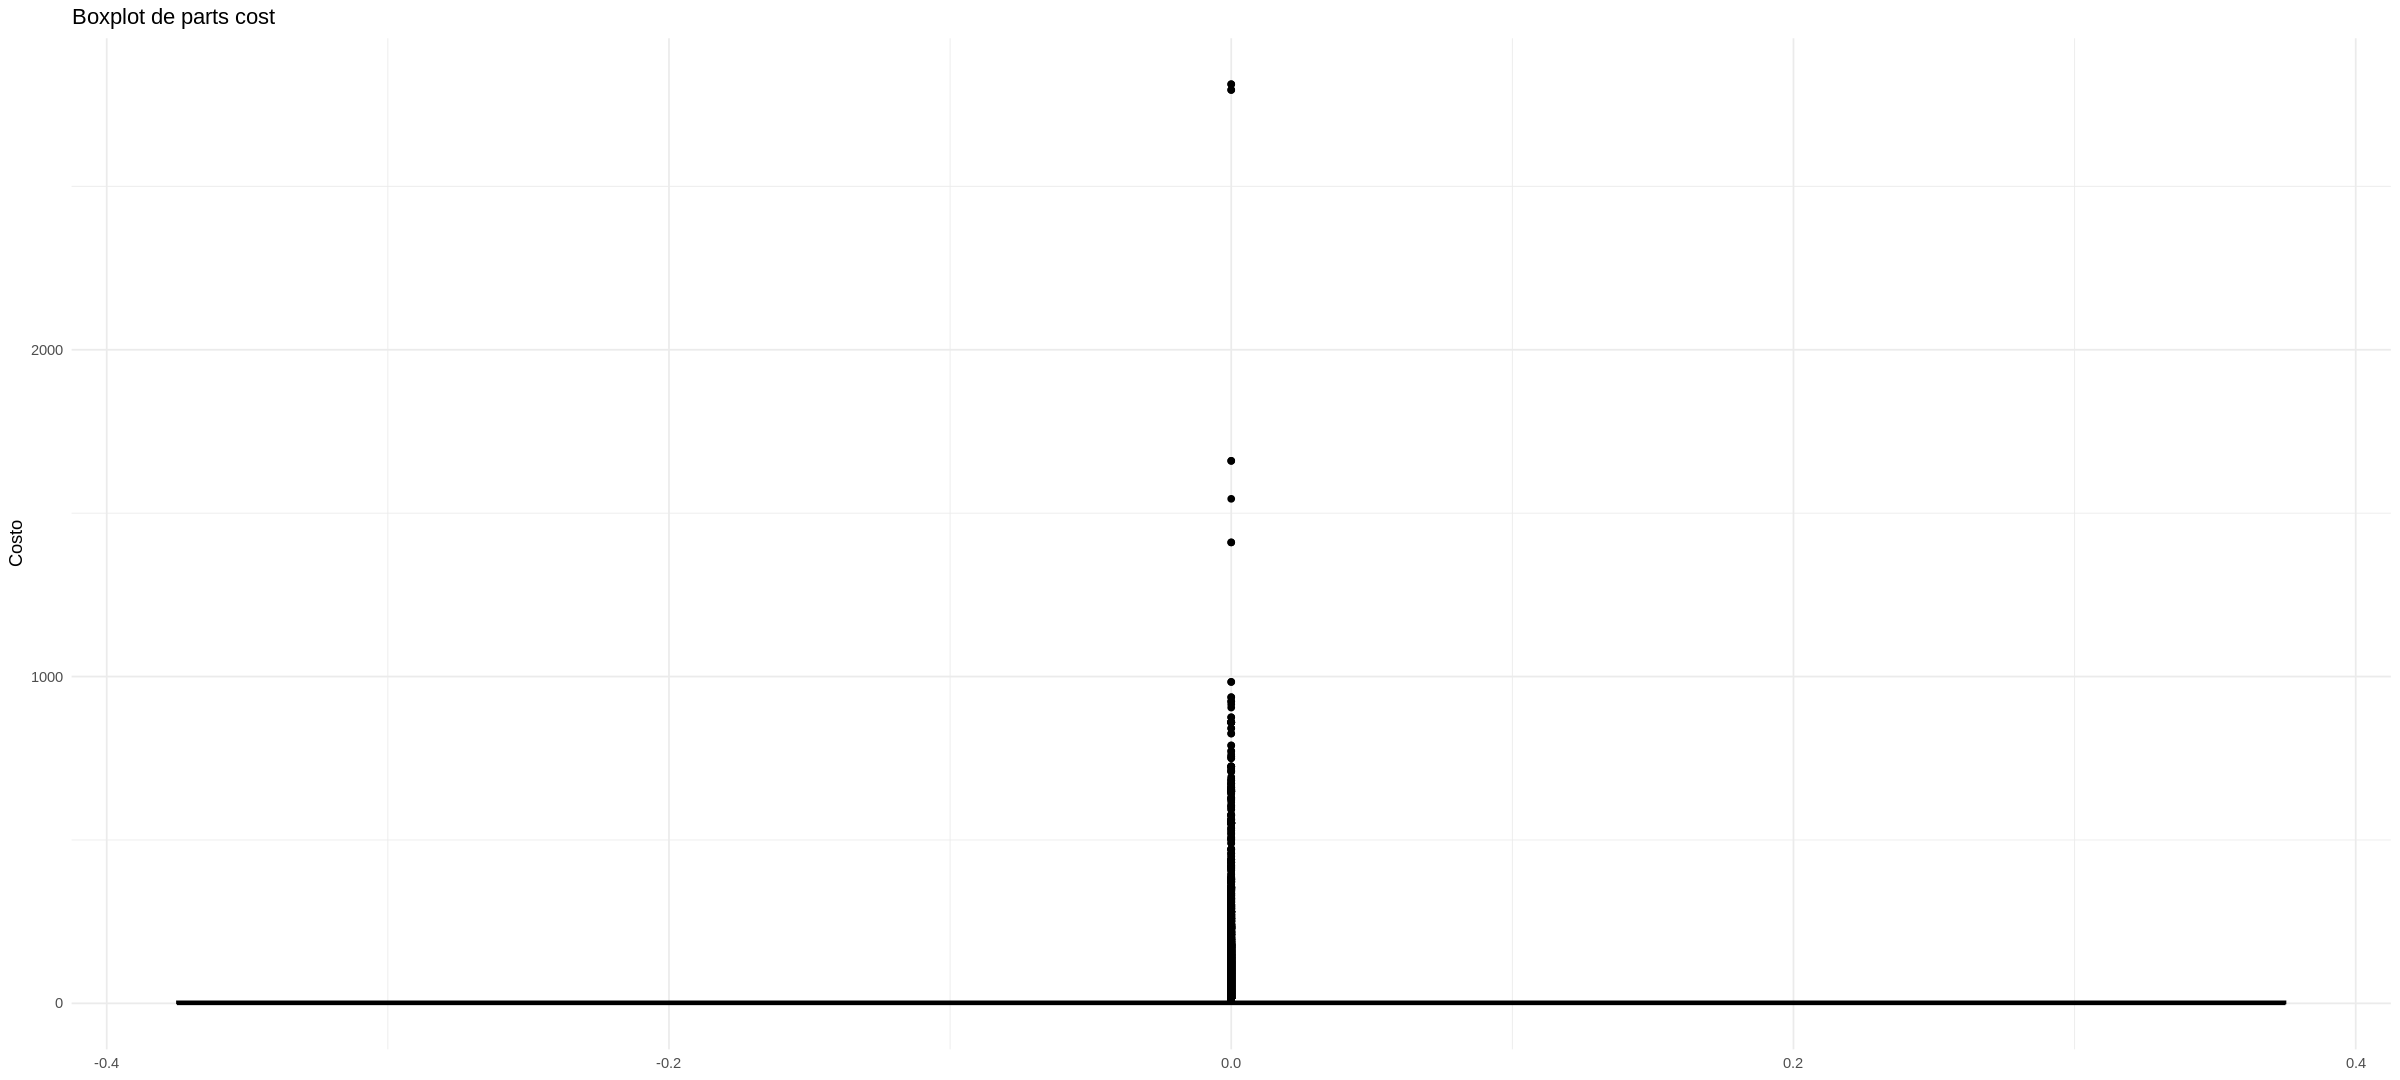

In [181]:
# Crear el boxplot de costo de partes
ggplot(df, aes(y = parts_cost)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de parts cost',
       y = 'Costo') +
  theme_minimal()

Warning message:
“Removed 2344 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


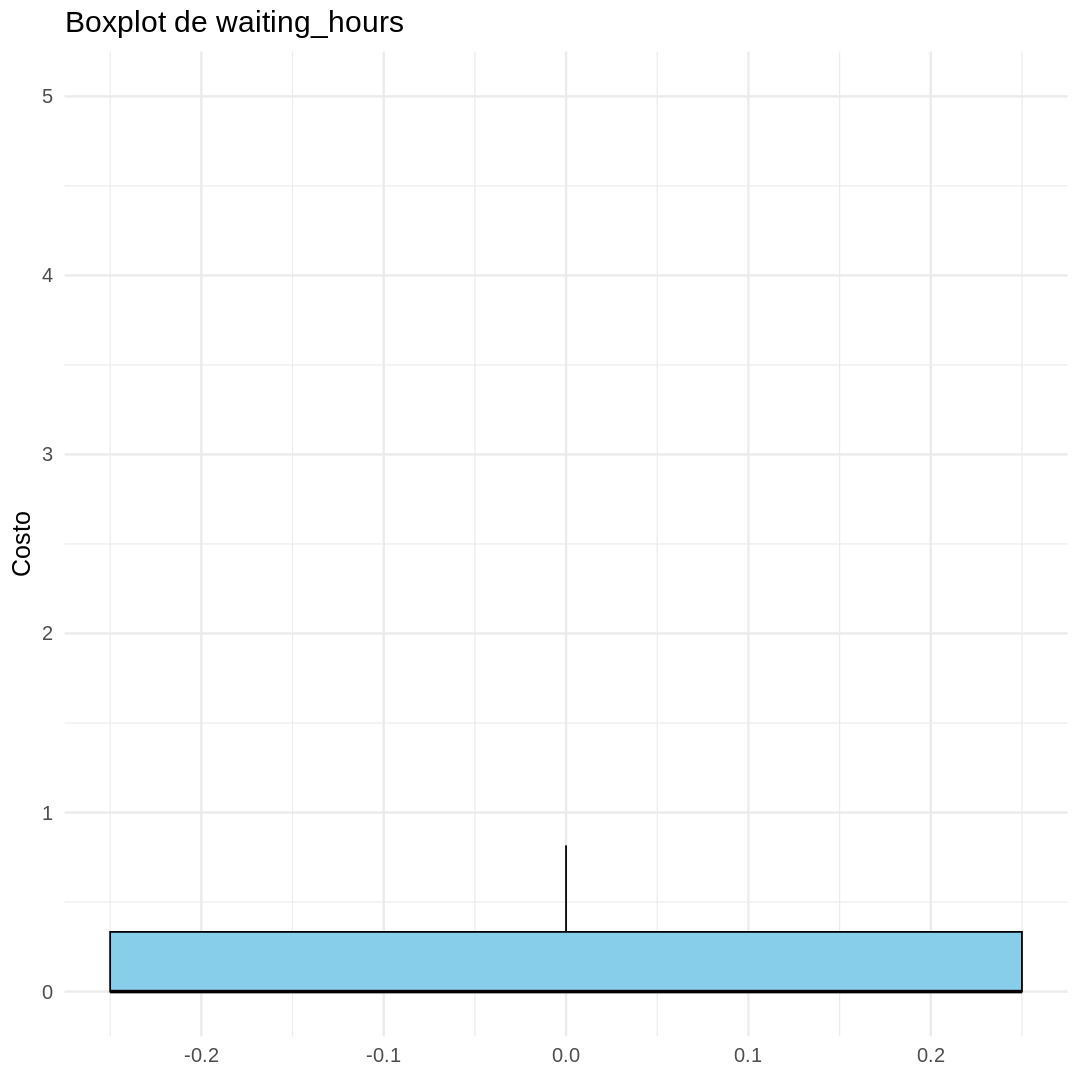

In [205]:
ggplot(df, aes(y = waiting_hours)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA, width = 0.5) +
  labs(title = 'Boxplot de waiting_hours',
       y = 'Costo') +
  theme_minimal(base_size = 15) +
  ylim(0, 5)

In [183]:
mean(df$parts_cost, na.rm = TRUE)      # Media
median(df$parts_cost, na.rm = TRUE)    # Mediana
sd(df$parts_cost, na.rm = TRUE)        # Desviación estándar
var(df$parts_cost, na.rm = TRUE)        # Varianza
range(df$parts_cost, na.rm = TRUE)      # Rango

[1] 12.11324

[1] 0

[1] 41.73935

[1] 1742.173

[1]    0.00 2812.49

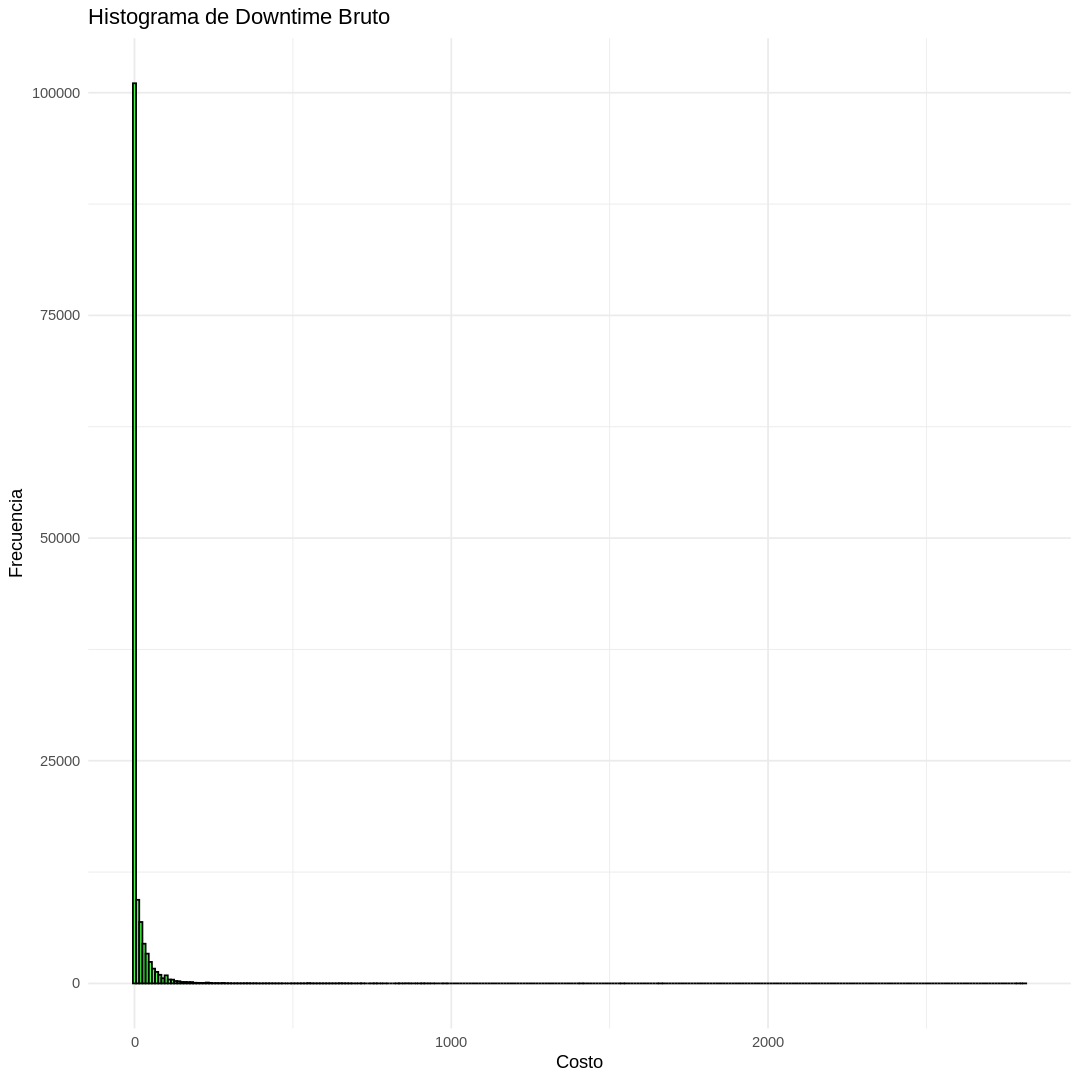

In [184]:
# Histograma de 'parts cost'
options(repr.plot.width=9, repr.plot.height=9)

hist_parts <- ggplot(df, aes(x = parts_cost)) +
  geom_histogram(binwidth = 10, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de Downtime Bruto",
       x = "Costo",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_parts)

**Variable waiting_hours**

Warning message:
“Removed 2344 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


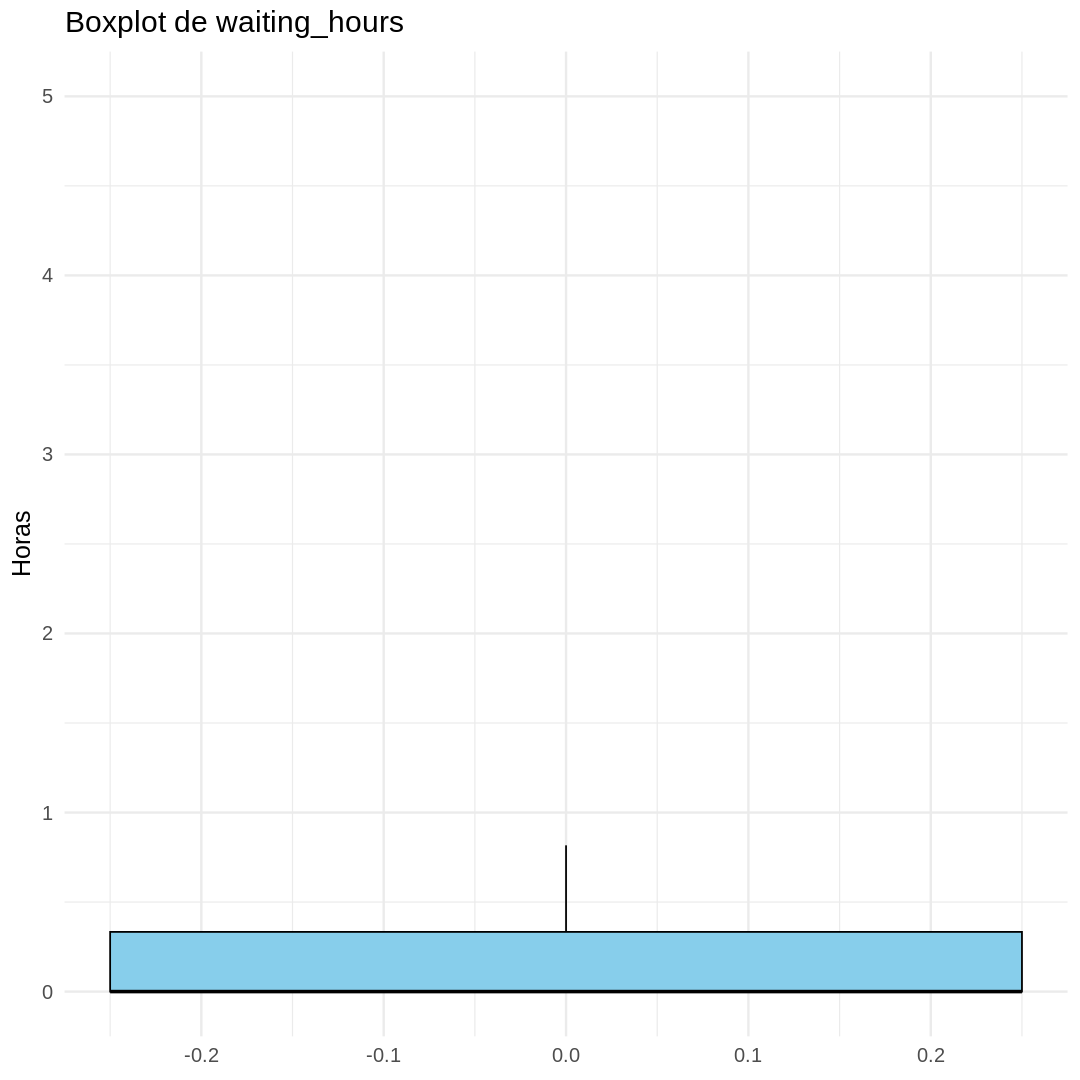

In [201]:
ggplot(df, aes(y = waiting_hours)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA, width = 0.5) +
  labs(title = 'Boxplot de waiting_hours',
       y = 'Horas') +
  theme_minimal(base_size = 15) +
  ylim(0, 5)

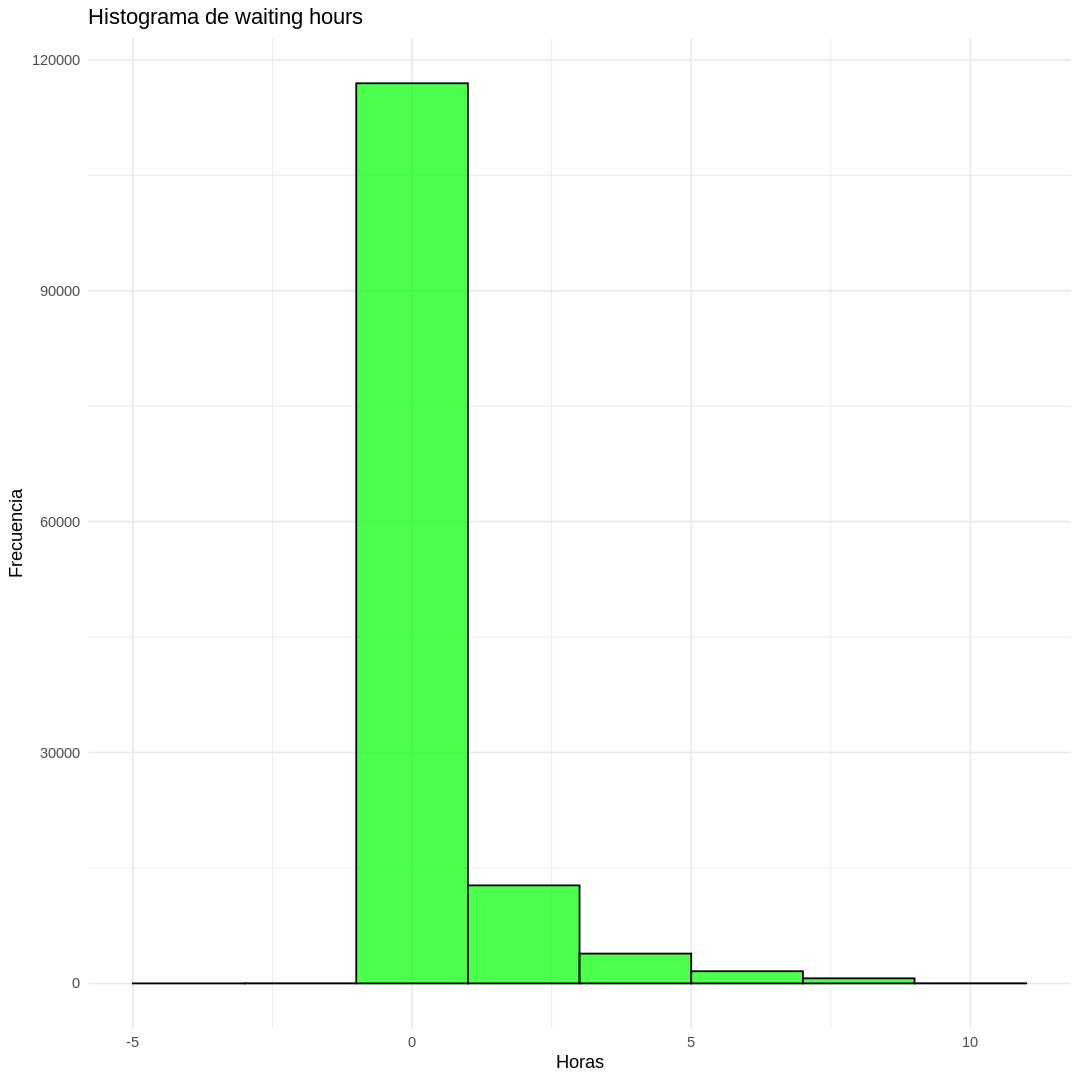

In [197]:
# Histograma de 'parts cost'
options(repr.plot.width=9, repr.plot.height=9)

hist_wait <- ggplot(df, aes(x = waiting_hours)) +
  geom_histogram(binwidth = 2, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de waiting hours",
       x = "Horas",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_wait)

# **ANALISIS DE VARIABLE OBJETIVO "DOWNTIME GROSS"**

In [186]:
summary(df$downtime_gross)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   25.00   50.00   87.97  110.00  835.00 

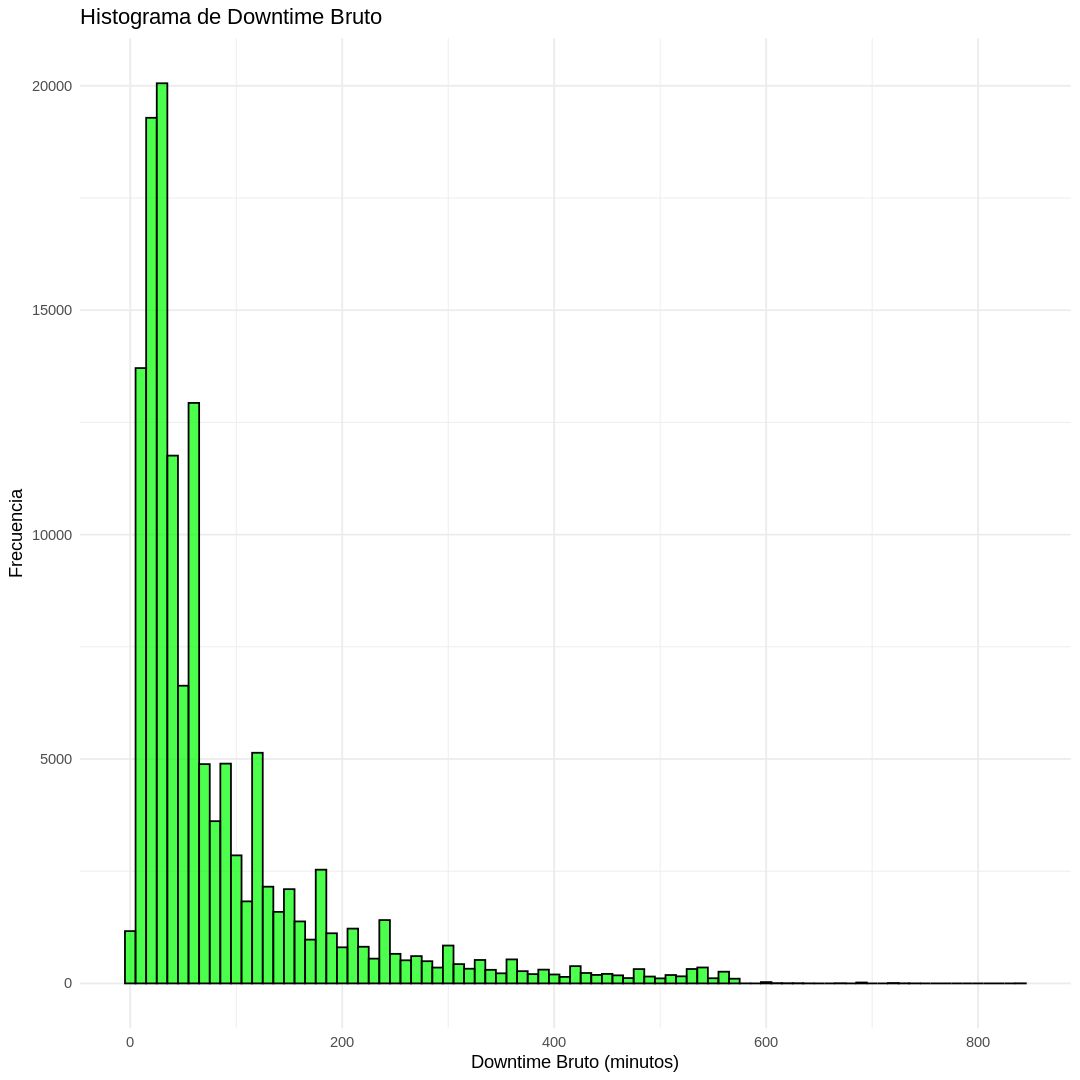

In [187]:
# Histograma de 'downtimeGross'
hist_downtimeGross <- ggplot(df, aes(x = downtime_gross)) +
  geom_histogram(binwidth = 10, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de Downtime Bruto",
       x = "Downtime Bruto (minutos)",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_downtimeGross)

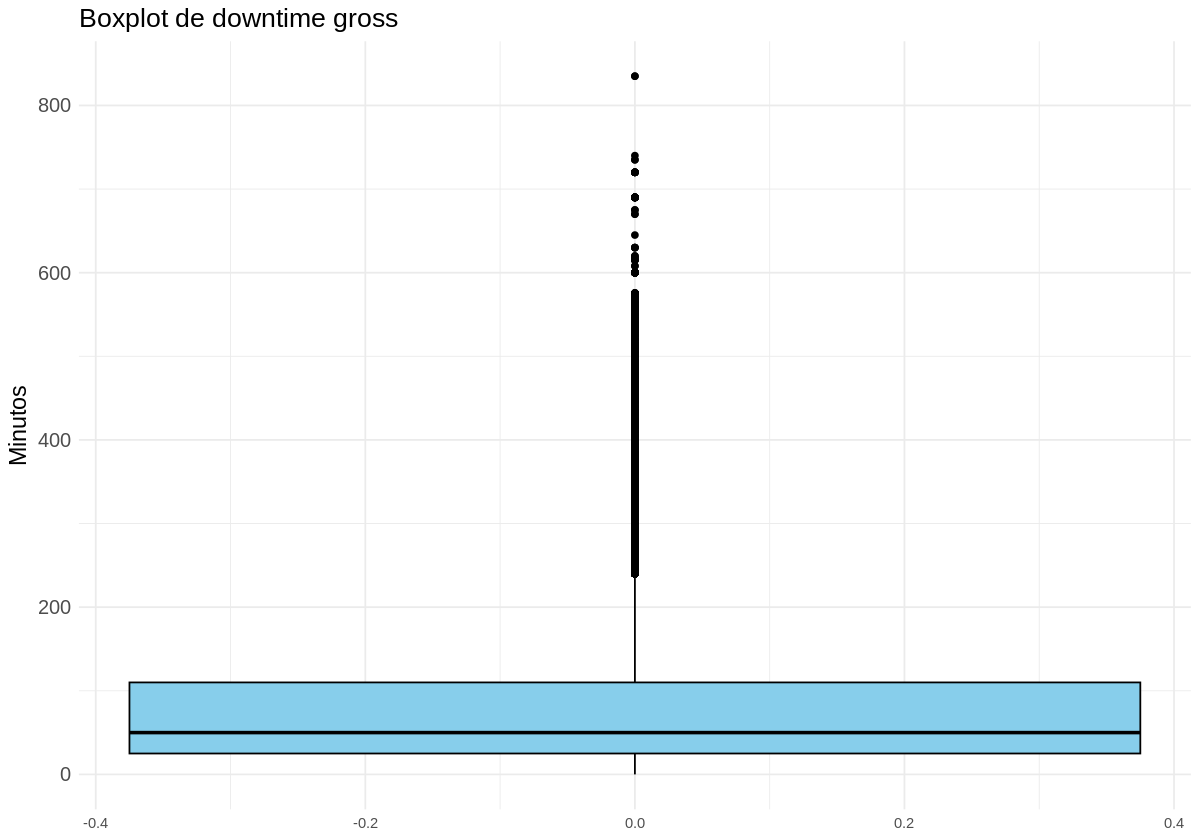

In [188]:
# Crear el boxplot de downtime gross
options(repr.plot.width=10, repr.plot.height=7)
ggplot(df, aes(y = downtime_gross)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de downtime gross',
       y = 'Minutos') +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 12), # Tamaño del texto del eje y
    axis.title.y = element_text(size = 14), # Tamaño del título del eje y
    plot.title = element_text(size = 16)    # Tamaño del título del gráfico
  )

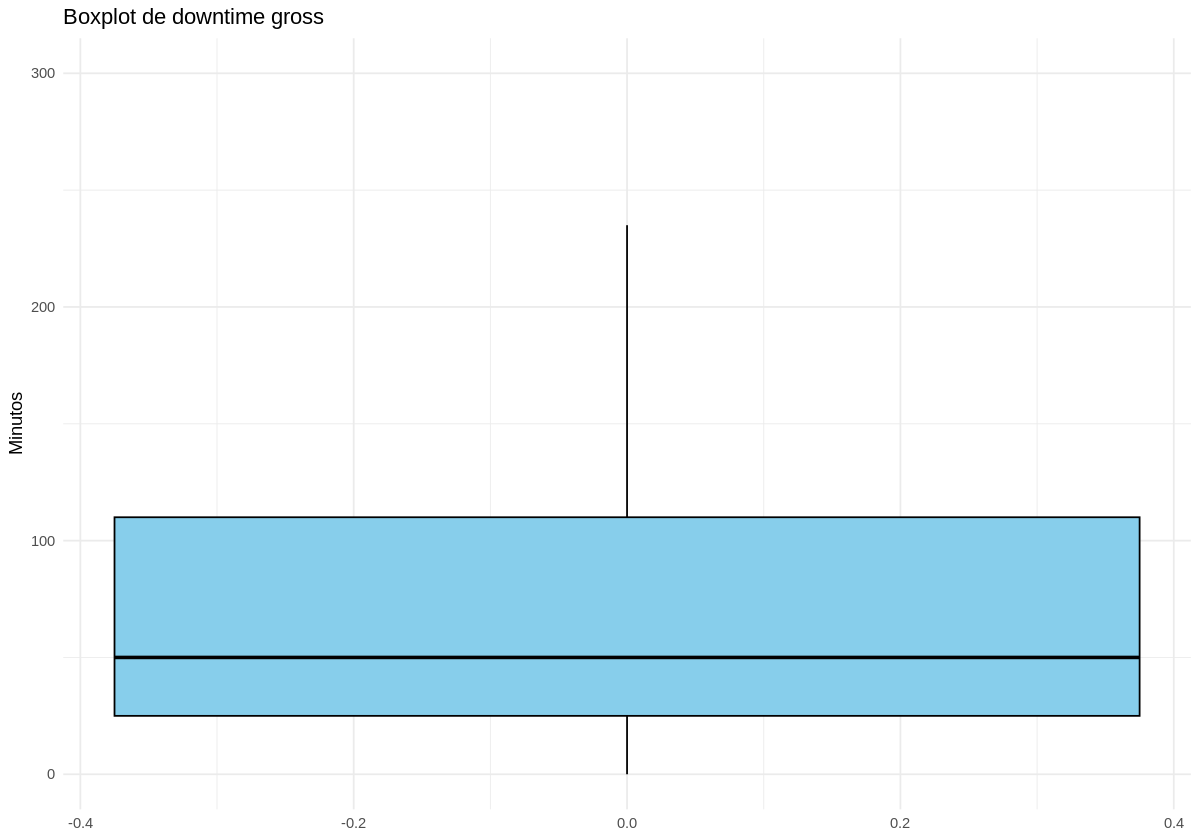

In [189]:
# Crear el boxplot de downtime gross
ggplot(df, aes(y = downtime_gross)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA) +
  labs(title = 'Boxplot de downtime gross',
       y = 'Minutos') +
  theme_minimal() + coord_cartesian(ylim = c(0, 300))

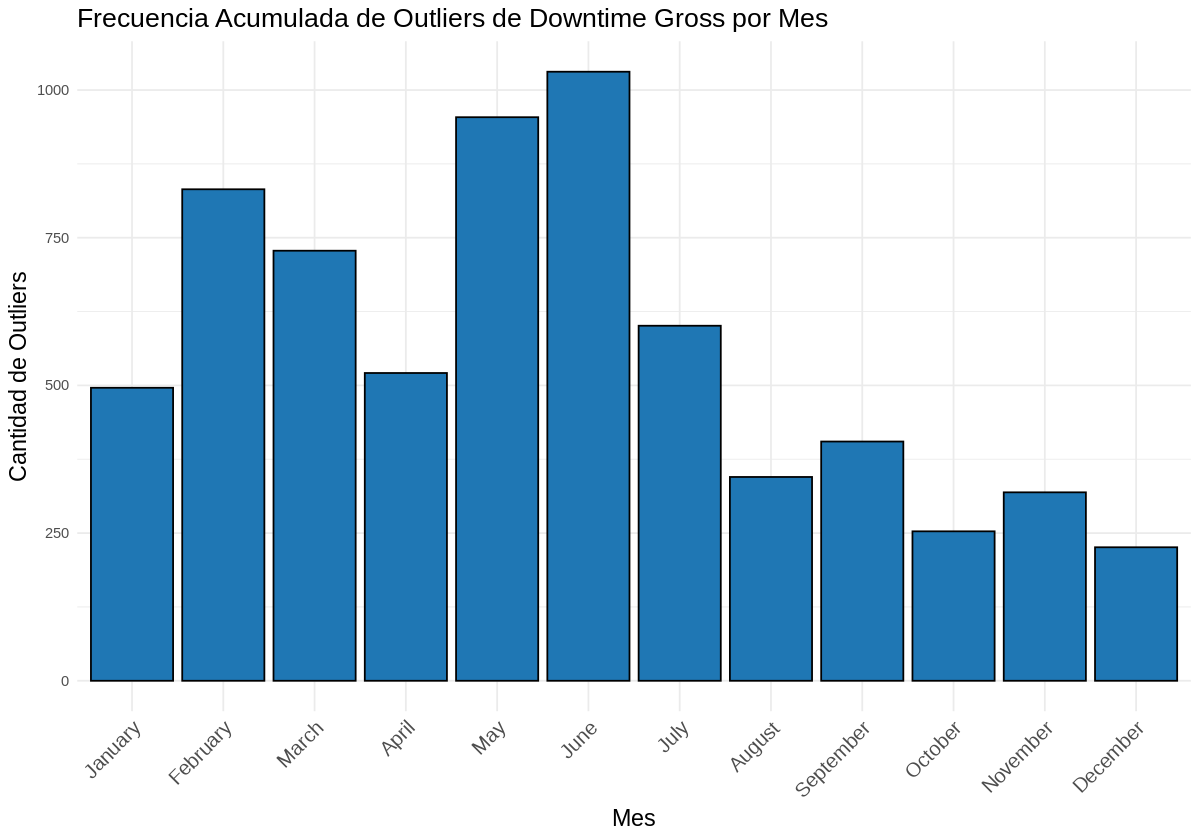

In [190]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Convertir la columna 'Date' a formato de fecha
df$date <- as.Date(df$date)

# Extraer solo el mes (sin el año) de la fecha
df <- df %>%
  mutate(Month = format(date, "%B")) # Nombre del mes

# Agrupar por mes y calcular la frecuencia acumulada de outliers
df_outliers <- df %>%
  group_by(Month) %>%
  summarise(Outliers = sum(outlier), .groups = 'drop') %>%
  arrange(match(Month, month.name)) # Ordenar por el orden de los meses

# Convertir la columna 'Month' a factor con el orden correcto
df_outliers$Month <- factor(df_outliers$Month, levels = month.name)

# Crear un gráfico de barras de la frecuencia acumulada de outliers por mes
ggplot(df_outliers, aes(x = Month, y = Outliers)) +
  geom_bar(stat = "identity", fill = "#1f77b4", color = 'black') + # Usar un color fijo
  labs(title = 'Frecuencia Acumulada de Outliers de Downtime Gross por Mes',
       x = 'Mes',
       y = 'Cantidad de Outliers') +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Tamaño y ángulo del texto del eje x
    axis.title.x = element_text(size = 14),                      # Tamaño del título del eje x
    axis.title.y = element_text(size = 14),                      # Tamaño del título del eje y
    plot.title = element_text(size = 16)                         # Tamaño del título del gráfico
  )

In [191]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers en el conjunto de datos original
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Filtrar por la operación "Hem Sleeve"
df_hem_sleeve <- df %>% filter(operation == "HEM SLEEVE")

# Contar los outliers para la operación "Hem Sleeve"
outliers_count <- sum(df_hem_sleeve$outlier)

# Imprimir el resultado
print(outliers_count)

[1] 2951


In [192]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers en el conjunto de datos original
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Filtrar por la operación "Hem Sleeve"
df_hem_sleeve <- df %>% filter(operation == "HEM SLEEVE")

# Contar los outliers para la operación "Hem Sleeve"
hem_sleeve_outliers_count <- sum(df_hem_sleeve$outlier)

# Contar el total de outliers en el DataFrame original
total_outliers_count <- sum(df$outlier)

# Calcular el porcentaje de outliers de "Hem Sleeve" respecto al total de outliers
percentage_hem_sleeve_outliers <- (hem_sleeve_outliers_count / total_outliers_count) * 100

# Imprimir el resultado
print(paste("El porcentaje de outliers de 'Hem Sleeve' respecto al total es:", round(percentage_hem_sleeve_outliers, 2), "%"))

[1] "El porcentaje de outliers de 'Hem Sleeve' respecto al total es: 43.97 %"


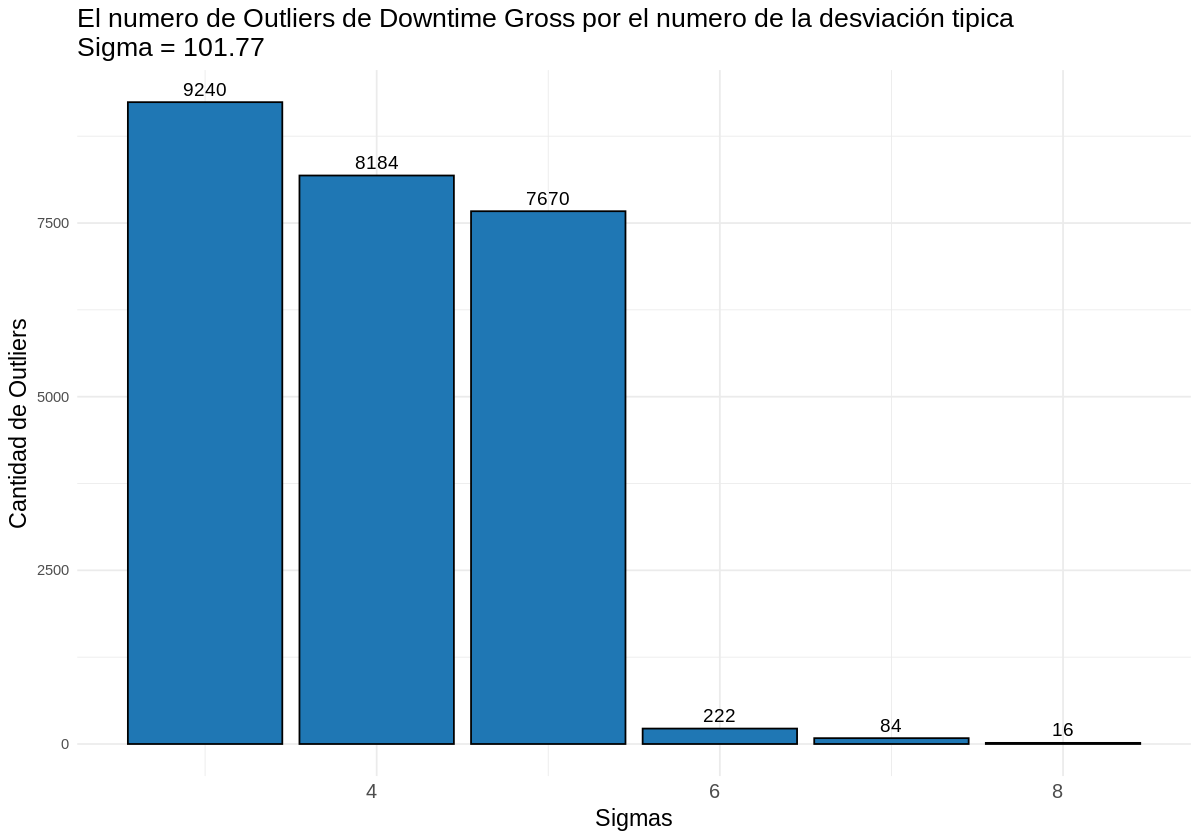

In [194]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers en el conjunto de datos original
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Calculamos la desviación tipica de la variable downtime_gross
sigma_dg = sd(df$downtime_gross)

# Calculamos el máximo de la variable downtime_gross
max_dg = max(df$downtime_gross)

# Agrupamos outliers por el numero de la desviación tipica
df_outliers <- df %>% filter(outlier == TRUE) %>%
                      #select(downtime_gross) %>%
                      mutate(num_sigma = floor(downtime_gross/sigma_dg)) %>%
                      group_by(num_sigma) %>%
                      summarise(num_outliers = sum(num_sigma), .groups = 'drop')

# Crear un gráfico de barras de outliers por el numero de sigmas
ggplot(df_outliers, aes(x = num_sigma, y = num_outliers)) +
  geom_bar(stat = "identity", fill = "#1f77b4", color = 'black') + # Usar un color fijo
  geom_text(aes(label = num_outliers),vjust = -0.5, hjust = +0.5, size = 4) +  # Ajuste del tamaño del texto
  labs(title = paste0('El numero de Outliers de Downtime Gross por el numero de la desviación tipica\nSigma = ', round(sigma_dg,2) ),
       x = 'Sigmas',
       y = 'Cantidad de Outliers') +
  theme_minimal() +
  theme(
    axis.text.x = element_text(hjust = 1, size = 12), # Tamaño del texto del eje x
    axis.title.x = element_text(size = 14),           # Tamaño del título del eje x
    axis.title.y = element_text(size = 14),           # Tamaño del título del eje y
    plot.title = element_text(size = 16)              # Tamaño del título del gráfico
  )

# **PRUEBA DE HIPOTESIS**

In [66]:
# Instalar e importar el paquete nortest
if (!require(nortest)) install.packages("nortest")
library(nortest)

In [17]:
ad_test <- ad.test(df$downtime_gross)
print(ad_test)

ERROR: Error in df$downtime_gross: object of type 'closure' is not subsettable


In [ ]:
# Crear un gráfico Q-Q
qqnorm(df$downtime_gross)
qqline(df$downtime_gross)

In [ ]:
kruskal.test(downtime_gross ~ failure_desc, data = df)

In [ ]:
install.packages("dunn.test")
library(dunn.test)

# Realizar la prueba de Dunn
dunn.test(df$downtime_gross, df$failure_desc, kw = TRUE)

In [ ]:
# Calcular la mediana de downtime_gross por cada categoría de failure_desc
median_values <- df %>%
  group_by(failure_desc) %>%
  summarise(median_downtime = median(downtime_gross))

# Mostrar los resultados
print(median_values)

In [ ]:
# Crear un gráfico de barras de las medianas
ggplot(median_values, aes(x = reorder(failure_desc, -median_downtime), y = median_downtime)) +
  geom_bar(stat = "identity") +
  xlab("Categoría de Falla") +
  ylab("Mediana del Tiempo de Inactividad") +
  ggtitle("Mediana del Tiempo de Inactividad por Categoría de Falla") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# **MODELOS GLM**



In [59]:
df <- select(df, -wo_type, -outlier, -Month)
#Comparar con un glm

In [60]:
head(df,5)

equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,waiting_hours,changed_pcs,Days_Between_Failures
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1011144,HEM SLEEVE,VC2700,Otros,Trim off device failure / Falla dispositivo corta desperdicio,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,Sharpen knife / Afilar cuchillas,DIEGO CUELLAR,2023-01-03,10,51.00,0,0,2
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.20,0,1,2
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.20,0,1,0
1027243,SET SLEEVE,VC2700,It sews with defect / Cose con defecto,Machine head failure sewing with defect / Falla cabezal cosiendo con defecto,Oil leak in machine head / Fuga de aceite lubricante en cabezal,Fix machine head oil leak / Corregir fuga de aceite en cabezal,Otros,2023-01-03,30,60.69,0,1,2
1027243,SET SLEEVE,VC2700,It sews with defect / Cose con defecto,Machine head failure sewing with defect / Falla cabezal cosiendo con defecto,Oil leak in machine head / Fuga de aceite lubricante en cabezal,Fix machine head oil leak / Corregir fuga de aceite en cabezal,Otros,2023-01-03,30,60.69,0,1,0


In [61]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data1 <- df[trainIndex, ]
validation_data1 <- df[validationIndex, ]
test_data1 <- df[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data1), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data1), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data1), "\n")

Dimensiones del conjunto de entrenamiento:  95100 14 
Dimensiones del conjunto de validación:  27171 14 
Dimensiones del conjunto de prueba:  13587 14 


In [62]:
# Inicializar y ajustar el modelo de regresión lineal
#Dividir en entrenamiento, test, validación por ejemplo 70,20,10
start_time <- Sys.time()
model1 <- glm(downtime_gross~. -equipment -downtime_gross -Days_Between_Failures -date -changed_pcs, data = train_data1)
end_time <- Sys.time()
training_time1 <- end_time - start_time
training_time1
# Resumen del modelo
summary(model1)

Time difference of 7.693047 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    Days_Between_Failures - date - changed_pcs, data = train_data1)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 17.010838
operationBARTACK                                                                             3.916412
operationBIND ARM                                                                           -5.673010
operationBIND LEG                                                                            2.637063
operationBIND NECK                                                                          -5.634968
operationCLOSE SLEEVE                                                                        4.823515
operationFLAT LOCK                                                                           1.430791
operationFLAT SEAM           

In [63]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model1, newdata = validation_data1)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data1$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  67.07267 
Validation MAE:  39.48481 
Validation R-squared:  0.5589545 


In [64]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model1, newdata = test_data1)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data1$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.92019 
Test MAE:  39.54054 
Test R-squared:  0.5657469 


**CALCULO DE VARIABLES**

In [65]:
#Calcular los fallos acumulativos
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Failure_Count = row_number())

In [66]:
# Calcular el costo acumulado de mantenimiento
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Maintenance_Cost = cumsum(parts_cost))

In [67]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data2 <- df[trainIndex, ]
validation_data2 <- df[validationIndex, ]
test_data2 <- df[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data2), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data2), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data2), "\n")

Dimensiones del conjunto de entrenamiento:  95100 16 
Dimensiones del conjunto de validación:  27171 16 
Dimensiones del conjunto de prueba:  13587 16 


**GLM PARA PREDECIR DOWNTIME CON VARIABLES CALCULADAS**

In [68]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model2 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data2)
end_time <- Sys.time()
training_time2 <- end_time - start_time
training_time2
# Resumen del modelo
summary(model2)

Time difference of 7.158427 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data2)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 1.963e+01
operationBARTACK                                                                            3.825e+00
operationBIND ARM                                                                          -5.856e+00
operationBIND LEG                                                                           2.342e+00
operationBIND NECK                                                                         -5.626e+00
operationCLOSE SLEEVE                                                                       4.889e+00
operationFLAT LOCK                                                                          1.204e+00
operationFLAT SEAM                                   

In [69]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model2, newdata = validation_data2)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data2$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  67.0423 
Validation MAE:  39.46484 
Validation R-squared:  0.5593538 


In [70]:
# Predecir con el conjunto de prueba (ya calculado, pero repitiendo para claridad)
test_predictions <- predict(model2, newdata = test_data2)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data2$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.86983 
Test MAE:  39.51634 
Test R-squared:  0.5664002 


**MODELO INCLUYENDO LA VARIABLE "MACHINE AGE"**

In [71]:
# Renombrar la columna 'Equipment' a 'equipment' en df_age
df_age <- df_age %>% rename(equipment = Equipment)

In [72]:
df_merged <- df %>%
  left_join(df_age %>% select(equipment, Age), by = "equipment")

In [73]:
head(df_merged,3)

equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,waiting_hours,changed_pcs,Days_Between_Failures,Cumulative_Failure_Count,Cumulative_Maintenance_Cost,Age
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1011144,HEM SLEEVE,VC2700,Otros,Trim off device failure / Falla dispositivo corta desperdicio,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,Sharpen knife / Afilar cuchillas,DIEGO CUELLAR,2023-01-03,10,51.0,0,0,2,1,51.0,26
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.2,0,1,2,1,19.2,23
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.2,0,1,0,2,38.4,23


In [74]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df_merged)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data3 <- df_merged[trainIndex, ]
validation_data3 <- df_merged[validationIndex, ]
test_data3 <- df_merged[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data3), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data3), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data3), "\n")

Dimensiones del conjunto de entrenamiento:  95100 17 
Dimensiones del conjunto de validación:  27171 17 
Dimensiones del conjunto de prueba:  13587 17 


In [75]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model3 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data3)
end_time <- Sys.time()
training_time3 <- end_time - start_time
training_time3
# Resumen del modelo
summary(model3)

Time difference of 7.471777 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data3)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 1.357e+01
operationBARTACK                                                                            4.893e+00
operationBIND ARM                                                                          -5.516e+00
operationBIND LEG                                                                           2.977e+00
operationBIND NECK                                                                         -5.032e+00
operationCLOSE SLEEVE                                                                       5.701e+00
operationFLAT LOCK                                                                          2.303e+00
operationFLAT SEAM                                   

In [76]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model3, newdata = validation_data3)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data3$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  67.01504 
Validation MAE:  39.44415 
Validation R-squared:  0.5597121 


In [77]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model3, newdata = test_data3)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data3$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.84893 
Test MAE:  39.49358 
Test R-squared:  0.5666711 


**MODELO INCLUYENDO LA VARIABLE "MECHANIC ANTIQUITY"**

In [78]:
# Primero, calcula la media de antiquity
mean_antiquity <- mean(df_mechanic$antiquity, na.rm = TRUE)

# Realiza el left join y luego reemplaza los NA en antiquity con la media calculada
df_merged2 <- df_merged %>%
  left_join(df_mechanic %>% select(mechanic, antiquity), by = "mechanic") %>%
  mutate(antiquity = ifelse(is.na(antiquity), mean_antiquity, antiquity))

In [79]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df_merged2)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data4 <- df_merged2[trainIndex, ]
validation_data4 <- df_merged2[validationIndex, ]
test_data4 <- df_merged2[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data4), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data4), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data4), "\n")

Dimensiones del conjunto de entrenamiento:  95100 18 
Dimensiones del conjunto de validación:  27171 18 
Dimensiones del conjunto de prueba:  13587 18 


In [80]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model4 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data4)
end_time <- Sys.time()
training_time4 <- end_time - start_time
training_time4
# Resumen del modelo
summary(model4)

Time difference of 7.321262 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data4)

Coefficients: (1 not defined because of singularities)
                                                                                             Estimate
(Intercept)                                                                                 1.357e+01
operationBARTACK                                                                            4.893e+00
operationBIND ARM                                                                          -5.516e+00
operationBIND LEG                                                                           2.977e+00
operationBIND NECK                                                                         -5.032e+00
operationCLOSE SLEEVE                                                                       5.701e+00
operationFLAT LOCK                                                                          2.303e+00
operationFLA

In [81]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model4, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  67.01504 
Validation MAE:  39.44415 
Validation R-squared:  0.5597121 


In [82]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model4, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.84893 
Test MAE:  39.49358 
Test R-squared:  0.5666711 


**MODELO INCLUYENDO LA VARIABLE "CHANGED_PCS"**

In [83]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model5 <- glm(downtime_gross~. -equipment -downtime_gross -date -antiquity, data = train_data4)
end_time <- Sys.time()
training_time5 <- end_time - start_time
training_time5
# Resumen del modelo
summary(model5)

Time difference of 7.311018 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - antiquity, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 1.409e+00
operationBARTACK                                                                            4.406e-02
operationBIND ARM                                                                          -7.398e-01
operationBIND LEG                                                                          -1.162e+00
operationBIND NECK                                                                         -4.564e-01
operationCLOSE SLEEVE                                                                       5.049e-01
operationFLAT LOCK                                                                          5.458e-01
operationFLAT SEAM                                     

In [84]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model5, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  17.72352 
Validation MAE:  14.92842 
Validation R-squared:  0.9692041 


In [85]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model5, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  17.56808 
Test MAE:  14.76287 
Test R-squared:  0.970072 


**IMPLEMENTACION DE FRONTWARD**

In [86]:
sapply(df_merged2, function(x) sum(is.na(x)))

equipment                   operation 
                          0                           0 
                 base_model                problem_desc 
                          0                           0 
               failure_desc                  cause_desc 
                          0                           0 
                action_desc                    mechanic 
                          0                           0 
                       date              downtime_gross 
                          0                           0 
                 parts_cost               waiting_hours 
                          0                           0 
                changed_pcs       Days_Between_Failures 
                          0                           0 
   Cumulative_Failure_Count Cumulative_Maintenance_Cost 
                          0                           0 
                        Age                   antiquity 
                          0                           0

In [87]:
# Realizar frontward elimination
model_null <- lm(downtime_gross ~ 1, data = train_data4)
model_forward <- step(model_null,
                      scope = list(lower = model_null, upper = model5),
                      direction = "forward")
model_forward$anova

Start:  AIC=879713.1
downtime_gross ~ 1

                              Df Sum of Sq       RSS    AIC
+ waiting_hours                1 506148508 483701696 811615
+ changed_pcs                  1 500060218 489789987 812805
+ mechanic                    85 132541098 857309106 866212
+ operation                   24  37878912 951971293 876050
+ base_model                  21  31230275 958619930 876706
+ action_desc                 28  27301122 962549082 877109
+ cause_desc                  28  25936370 963913834 877244
+ problem_desc                 2  23905344 965944861 877392
+ parts_cost                   1   9364447 980485758 878811
+ failure_desc                 3   7565519 982284685 878989
+ Age                          1   5831346 984018859 879153
+ Days_Between_Failures        1   3883037 985967168 879341
+ Cumulative_Maintenance_Cost  1   3396562 986453643 879388
+ Cumulative_Failure_Count     1   1080976 988769228 879611
<none>                                     989850205 879713

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,95099,989850205,879713.1
+ waiting_hours,-1,5.061485e+08,95098,483701696,811615.4
+ changed_pcs,-1,4.527020e+08,95097,30999742,550331.2
+ mechanic,-85,1.099658e+06,95012,29900084,547066.4
+ action_desc,-28,5.859497e+04,94984,29841489,546935.8
+ parts_cost,-1,1.690838e+04,94983,29824581,546883.9
+ base_model,-21,2.132620e+04,94962,29803254,546857.9
+ cause_desc,-28,2.668795e+04,94934,29776566,546828.7
+ failure_desc,-3,6.760718e+03,94931,29769806,546813.1


In [88]:
formula = as.formula("downtime_gross ~ waiting_hours + changed_pcs + mechanic + action_desc +
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost +
    Cumulative_Failure_Count")

In [89]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model6 <- glm(formula = formula, data = train_data4)
end_time <- Sys.time()
training_time6 <- end_time - start_time
training_time6
# Resumen del modelo
summary(model6)

Time difference of 5.320372 secs


Call:
glm(formula = formula, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 1.382e+00
waiting_hours                                                                               5.991e+01
changed_pcs                                                                                 5.490e+01
mechanicAdalberto Jeremias Rodriguez Zometa                                                -6.288e-01
mechanicAlfonso Escobar                                                                    -2.490e+00
mechanicAnthony Murillo                                                                     1.101e+01
mechanicAntony Ulloa                                                                        1.131e+01
mechanicCain Alfredo Ramirez                                                                1.297e+00
mechanicCarlos Al

In [90]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model6, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  17.56432 
Test MAE:  14.7602 
Test R-squared:  0.9700848 


In [91]:
formula2 = as.formula("downtime_gross ~ waiting_hours + changed_pcs*mechanic + action_desc +
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost +
    Cumulative_Failure_Count")

**MODELO CON INTERACCIÓN DE MECHANIC Y CHANGED PIECES**

In [92]:
# Inicializar y ajustar el modelo de regresión lineal
# Medir el tiempo de entrenamiento
start_time <- Sys.time()
model7 <- glm(formula = formula2, data = train_data4)
end_time <- Sys.time()
training_time8 <- end_time - start_time
training_time8
# Resumen del modelo
summary(model7)

Time difference of 11.55823 secs


Call:
glm(formula = formula2, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 1.332e+00
waiting_hours                                                                               5.999e+01
changed_pcs                                                                                 5.514e+01
mechanicAdalberto Jeremias Rodriguez Zometa                                                 8.376e+00
mechanicAlfonso Escobar                                                                    -5.780e+00
mechanicAnthony Murillo                                                                     1.564e+01
mechanicAntony Ulloa                                                                        1.227e+01
mechanicCain Alfredo Ramirez                                                                2.813e+00
mechanicCarlos A

In [93]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model7, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  17.13446 
Test MAE:  14.13176 
Test R-squared:  0.9715312 


In [94]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model7, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  17.33637 
Validation MAE:  14.3182 
Validation R-squared:  0.9705348 


In [95]:
# Lista de todas las variables independientes disponibles
variables <- c("changed_pcs", "mechanic", "operation", "cause_desc",
               "problem_desc", "Age", "base_model", "action_desc",
               "failure_desc", "Days_Between_Failures",
               "Cumulative_Maintenance_Cost", "parts_cost", "waiting_hours")

# Crear una lista para almacenar los modelos y un data frame para los resultados
modelos <- list()
resultados <- data.frame(Modelo = character(), Variables = character(), Error = numeric(), R_Squared = numeric(), stringsAsFactors = FALSE)

set.seed(123)  # Fijar semilla para reproducibilidad

# Bucle para iterar y ajustar 50 modelos
for (i in 1:50) {
  # Seleccionar aleatoriamente un subconjunto de variables
  selected_vars <- sample(variables, size = sample(1:length(variables), 1))  # Tamaño del subconjunto también aleatorio

  # Definir la fórmula del modelo usando las variables seleccionadas
  formula <- as.formula(paste("downtime_gross ~", paste(selected_vars, collapse = " + ")))

  # Ajustar el modelo GLM
  modelo <- glm(formula, data = train_data4, family = gaussian())

  # Almacenar el modelo en la lista
  modelos[[paste("modelo", i, sep = "_")]] <- modelo

  # Calcular el Error Absoluto Medio (MAE)
  predicciones <- predict(modelo, validation_data4)
  mae <- mean(abs(validation_data4$downtime_gross - predicciones))

  # Calcular el R cuadrado
  ss_total <- sum((validation_data4$downtime_gross - mean(validation_data4$downtime_gross))^2)
  ss_residual <- sum((validation_data4$downtime_gross - predicciones)^2)
  r_squared <- 1 - (ss_residual / ss_total)

  # Almacenar los resultados en el data frame
  resultados <- rbind(resultados, data.frame(Modelo = paste("Modelo", i), Variables = paste(selected_vars, collapse = ", "), Error = mae, R_Squared = r_squared))
}

# Ver los resultados
resultados

Modelo,Variables,Error,R_Squared
<chr>,<chr>,<dbl>,<dbl>
Modelo 1,"operation, Days_Between_Failures, mechanic",62.22792,0.132524802
Modelo 2,"Cumulative_Maintenance_Cost, problem_desc, cause_desc, Age, failure_desc, mechanic",61.85195,0.134522757
Modelo 3,"problem_desc, operation, Cumulative_Maintenance_Cost, failure_desc, Days_Between_Failures, changed_pcs, waiting_hours, parts_cost, mechanic, Age, base_model",14.95328,0.969148763
Modelo 4,"operation, cause_desc, changed_pcs, base_model, problem_desc, parts_cost, Days_Between_Failures, mechanic, failure_desc",39.73778,0.562541911
Modelo 5,"failure_desc, waiting_hours, Days_Between_Failures, base_model, problem_desc, Cumulative_Maintenance_Cost, parts_cost",41.91838,0.526518419
Modelo 6,"Age, failure_desc, mechanic, problem_desc, action_desc, cause_desc, base_model, Days_Between_Failures, Cumulative_Maintenance_Cost, changed_pcs, parts_cost",39.74948,0.560026717
Modelo 7,"failure_desc, Age, problem_desc, waiting_hours, cause_desc, parts_cost, action_desc, operation, changed_pcs, mechanic, Days_Between_Failures",14.92947,0.969201221
Modelo 8,mechanic,62.37292,0.120730628
Modelo 9,"waiting_hours, problem_desc, Age, operation",42.49031,0.518645473


In [96]:
write.csv(resultados, "resultados.csv", row.names = TRUE)

In [97]:
residuals <- residuals(model6)

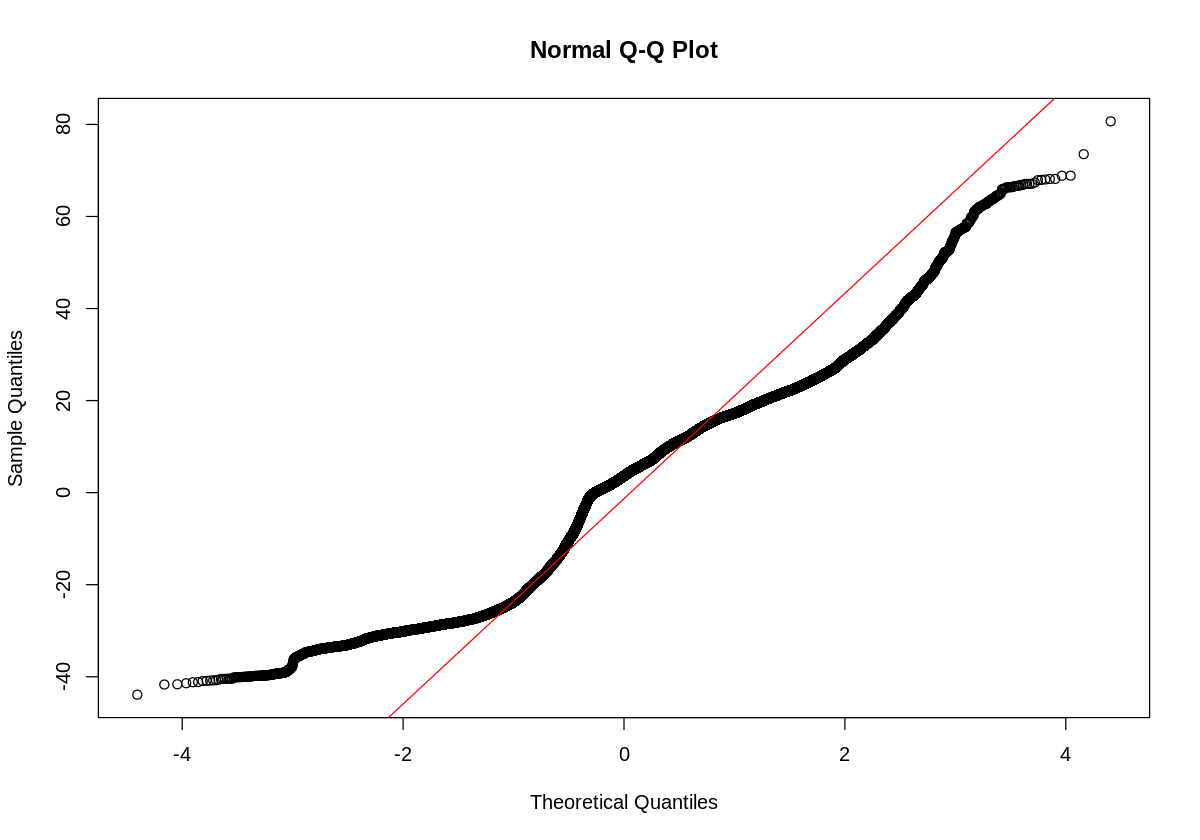

In [98]:
qqnorm(residuals)
qqline(residuals, col = "red")

In [99]:
install.packages("nortest")
library(nortest)
ad_test <- ad.test(residuals)
print(ad_test)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




	Anderson-Darling normality test

data:  residuals
A = 1805.7, p-value < 2.2e-16



# **MODELO RANDOM FOREST**

In [ ]:
# Entrenar el modelo de Random Forest
start_time <- Sys.time()
model_rf <- randomForest(downtime_gross ~ waiting_hours + changed_pcs + mechanic + action_desc +
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost +
    Cumulative_Failure_Count, data = train_data4, importance = TRUE)
end_time <- Sys.time()
training_time7 <- end_time - start_time
training_time7
# Ver el resumen del modelo
print(model_rf)

Time difference of 58.32582 mins


Call:
 randomForest(formula = downtime_gross ~ waiting_hours + changed_pcs +      mechanic + action_desc + parts_cost + base_model + cause_desc +      failure_desc + Cumulative_Maintenance_Cost + Cumulative_Failure_Count,      data = train_data4, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 134.1744
                    % Var explained: 98.71


In [ ]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model_rf, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  11.47622 
Validation MAE:  8.354358 
Validation R-squared:  0.9870881 


In [ ]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model_rf, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  11.27007 
Test MAE:  8.209747 
Test R-squared:  0.9876837 


In [ ]:
residuals <- test_data4$downtime_gross - test_predictions

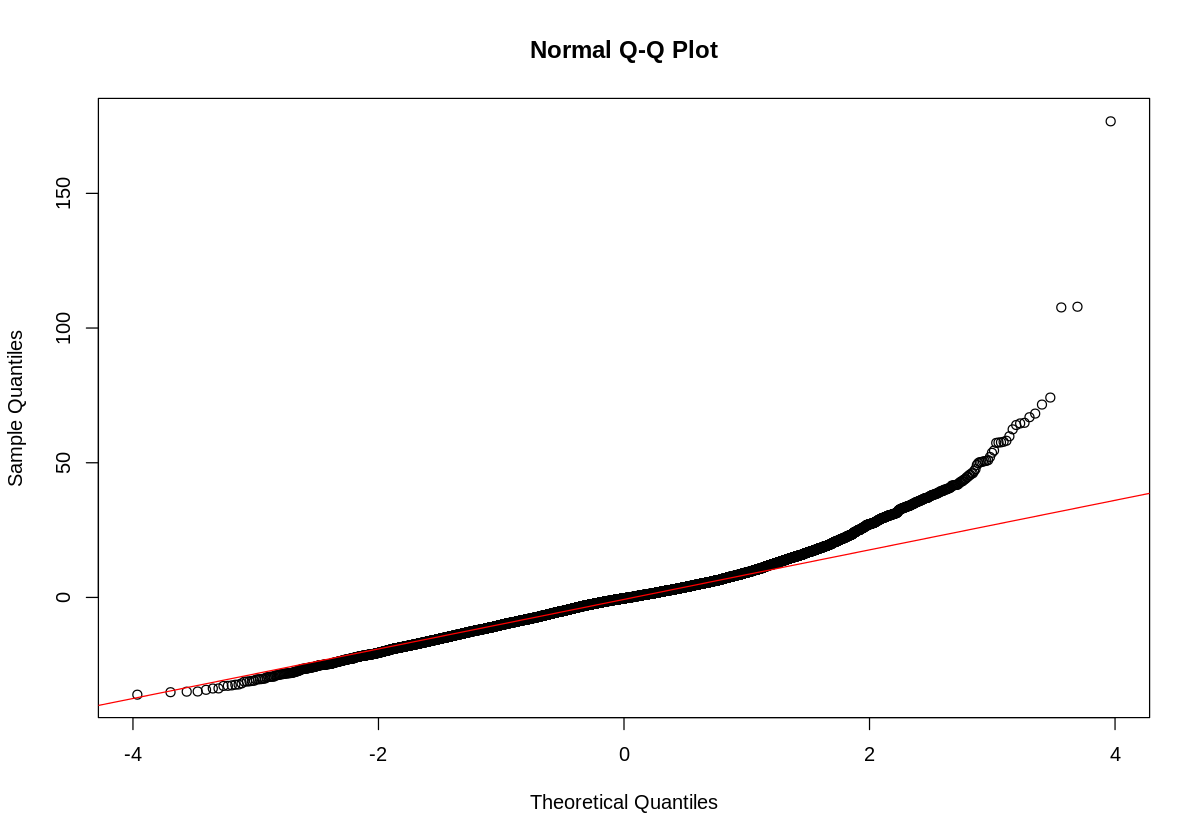

In [ ]:
qqnorm(residuals)
qqline(residuals, col = "red")

,%IncMSE,IncNodePurity
waiting_hours,741.67870,477860614
changed_pcs,672.94543,450513424
mechanic,36.77166,10517527
action_desc,29.09862,4184402
parts_cost,18.96908,10697667
base_model,36.10069,5669347
cause_desc,29.33269,5847152
failure_desc,33.18387,2170247
Cumulative_Maintenance_Cost,25.14931,9514549
Cumulative_Failure_Count,30.85235,7424983


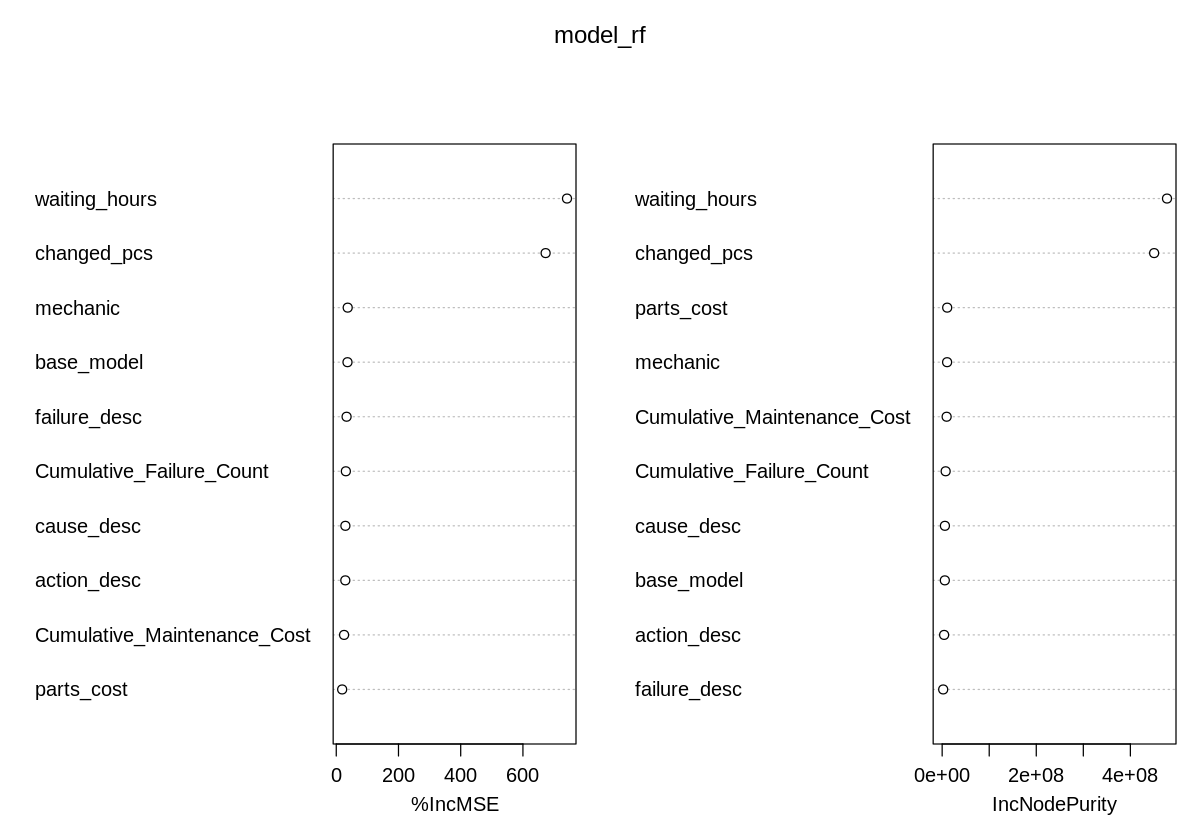

In [ ]:
# Ver la importancia de las variables
importance(model_rf)
varImpPlot(model_rf)

In [ ]:
install.packages("nortest")
library(nortest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
ad_test <- ad.test(residuals)
print(ad_test)


	Anderson-Darling normality test

data:  residuals
A = 90.865, p-value < 2.2e-16



# MODELO SVM

In [ ]:
# Instalar el paquete e1071 si no lo tienes
install.packages("e1071")

# Cargar el paquete
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Medir el tiempo de entrenamiento
start_time <- Sys.time()

# Ajustar el modelo SVM
model_svm <- svm(downtime_gross ~ waiting_hours + changed_pcs + mechanic + action_desc +
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost +
    Cumulative_Failure_Count, data = train_data4, kernel = "radial", cost = 1, gamma = 0.1)

end_time <- Sys.time()
training_time_svm <- end_time - start_time

# Mostrar el tiempo de entrenamiento
print(training_time_svm)

# Ver el resumen del modelo SVM
print(model_svm)

Time difference of 1.150458 hours

Call:
svm(formula = downtime_gross ~ waiting_hours + changed_pcs + mechanic + 
    action_desc + parts_cost + base_model + cause_desc + failure_desc + 
    Cumulative_Maintenance_Cost + Cumulative_Failure_Count, data = train_data4, 
    kernel = "radial", cost = 1, gamma = 0.1)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.1 
    epsilon:  0.1 


Number of Support Vectors:  37835



In [ ]:
# Predecir con el conjunto de validación usando el modelo SVM
validation_predictions_svm <- predict(model_svm, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse_svm <- sqrt(mean((validation_predictions_svm - validation_actuals)^2))
validation_mae_svm <- mean(abs(validation_predictions_svm - validation_actuals))
validation_r2_svm <- 1 - (sum((validation_predictions_svm - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE (SVM): ", validation_rmse_svm, "\n")
cat("Validation MAE (SVM): ", validation_mae_svm, "\n")
cat("Validation R-squared (SVM): ", validation_r2_svm, "\n")

Validation RMSE (SVM):  12.85015 
Validation MAE (SVM):  9.856853 
Validation R-squared (SVM):  0.9838114 


In [ ]:
# Predecir con el conjunto de prueba usando el modelo SVM
test_predictions_svm <- predict(model_svm, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse_svm <- sqrt(mean((test_predictions_svm - test_actuals)^2))
test_mae_svm <- mean(abs(test_predictions_svm - test_actuals))
test_r2_svm <- 1 - (sum((test_predictions_svm - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE (SVM): ", test_rmse_svm, "\n")
cat("Test MAE (SVM): ", test_mae_svm, "\n")
cat("Test R-squared (SVM): ", test_r2_svm, "\n")

Test RMSE (SVM):  12.6631 
Test MAE (SVM):  9.743881 
Test R-squared (SVM):  0.9844508 


# **MODELO GRADIENT BOOSTING**

**Cargamos la librería gbm**

In [ ]:
install.packages('gbm')
library(gbm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



In [ ]:
dim(train_data4)
dim(validation_data4)
dim(test_data4)

[1] 95100    18

[1] 27171    18

[1] 13587    18

In [ ]:
glimpse(test_data4)

Rows: 13,587
Columns: 18
Groups: equipment [4,253]
$ equipment                   <dbl> 1013453, 1027243, 1111960, 1111952, 113265…
$ operation                   <chr> "TOP STITCH", "SET SLEEVE", "TAPE SHOULDER…
$ base_model                  <chr> "VC2713", "VC2700", "LDA-L26", "LDA-L26", …
$ problem_desc                <chr> "It sews with defect / Cose con defecto", …
$ failure_desc                <chr> "Machine head failure stopping sewing  / F…
$ cause_desc                  <chr> "Misadjusted machine head needle guard / G…
$ action_desc                 <chr> "Adjust machine head needle guard / Ajusta…
$ mechanic                    <chr> "Adalberto Jeremias Rodriguez Zometa", "Ot…
$ date                        <date> 2023-01-03, 2023-01-03, 2023-01-03, 2023-…
$ downtime_gross              <dbl> 60, 30, 20, 20, 20, 20, 120, 65, 65, 15, 1…
$ parts_cost                  <dbl> 19.20, 60.69, 8.60, 75.22, 2.48, 0.00, 1.1…
$ waiting_hours               <dbl> 0.00000000, 0.00000000, 0.0000000

**Numerización**

Convertimos a numérico las variables **operation, base_model, problem_desc, failure_desc, cause_desc, action_desc, mechanic** que contienen datos textuales.

In [ ]:
install.packages("superml")
library(superml)
library(scales)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘assertthat’, ‘Metrics’, ‘BH’, ‘RcppArmadillo’


Loading required package: R6


Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor




In [ ]:
encoder1 <- LabelEncoder$new()
encoder2 <- LabelEncoder$new()
encoder3 <- LabelEncoder$new()
encoder4 <- LabelEncoder$new()
encoder5 <- LabelEncoder$new()
encoder6 <- LabelEncoder$new()
encoder7 <- LabelEncoder$new()

data_for_gb <- rbind(rbind(train_data4, validation_data4), test_data4)

data_for_gb$operation <- encoder1$fit_transform(data_for_gb$operation)
data_for_gb$base_model <- encoder2$fit_transform(data_for_gb$base_model)
data_for_gb$problem_desc <- encoder3$fit_transform(data_for_gb$problem_desc)
data_for_gb$failure_desc <- encoder4$fit_transform(data_for_gb$failure_desc)
data_for_gb$cause_desc <- encoder5$fit_transform(data_for_gb$cause_desc)
data_for_gb$action_desc <- encoder6$fit_transform(data_for_gb$action_desc)
data_for_gb$mechanic <- encoder7$fit_transform(data_for_gb$mechanic)

data_for_gb$changed_pcs <- rescale(data_for_gb$changed_pcs)
data_for_gb$mechanic <- rescale(data_for_gb$mechanic)
data_for_gb$operation <- rescale(data_for_gb$operation)
data_for_gb$cause_desc <- rescale(data_for_gb$cause_desc)
data_for_gb$problem_desc <- rescale(data_for_gb$problem_desc)
data_for_gb$Age <- rescale(data_for_gb$Age)
data_for_gb$base_model <- rescale(data_for_gb$base_model)
data_for_gb$action_desc <- rescale(data_for_gb$action_desc)
data_for_gb$failure_desc <- rescale(data_for_gb$failure_desc)
data_for_gb$Days_Between_Failures <- rescale(data_for_gb$Days_Between_Failures)
data_for_gb$Cumulative_Maintenance_Cost <- rescale(data_for_gb$Cumulative_Maintenance_Cost)
data_for_gb$parts_cost <- rescale(data_for_gb$parts_cost)

head(data_for_gb, 6)

equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,waiting_hours,changed_pcs,Days_Between_Failures,Cumulative_Failure_Count,Cumulative_Maintenance_Cost,Age,antiquity
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1053182,0.00000000,0.00000000,0,0.0000000,0.00000000,0.00000000,0.00000000,2024-06-13,65,0.00000000,0.6666667,0.00000000,0.003703704,8,0.009118865,0.2083333,4
1166559,0.04166667,0.04761905,0,0.3333333,0.03571429,0.03571429,0.01176471,2024-04-15,30,0.00000000,0.0000000,0.07142857,0.000000000,9,0.001610208,0.9166667,6
1098111,0.08333333,0.09523810,0,0.3333333,0.07142857,0.07142857,0.02352941,2023-12-06,15,0.02612632,0.0000000,0.00000000,0.068518519,41,0.125397709,0.7916667,10
156969,0.12500000,0.04761905,0,0.0000000,0.03571429,0.07142857,0.00000000,2024-04-18,25,0.00000000,0.0000000,0.00000000,0.064814815,27,0.085688515,1.0000000,4
1074713,0.16666667,0.00000000,0,0.6666667,0.07142857,0.10714286,0.03529412,2023-05-25,115,0.00000000,1.5000000,0.00000000,0.000000000,25,0.018075498,0.8333333,1
1058856,0.20833333,0.14285714,0,0.6666667,0.10714286,0.00000000,0.04705882,2023-07-18,15,0.00000000,0.1666667,0.00000000,0.027777778,24,0.005133296,0.8750000,8


In [ ]:
# Crear conjuntos de entrenamiento, validación y prueba para el modelo de Gradient Boosting

train_data5 <- data_for_gb[1:nrow(train_data4),]
validation_data5 <- data_for_gb[(nrow(train_data4)+1):(nrow(train_data4) + nrow(validation_data4)),]
test_data5 <- data_for_gb[(nrow(train_data4) + nrow(validation_data4)+1):(nrow(train_data4) + nrow(validation_data4)+nrow(test_data4)),]

dim(train_data5)
dim(validation_data5)
dim(test_data5)

[1] 95100    18

[1] 27171    18

[1] 13587    18

In [ ]:
formula

downtime_gross ~ waiting_hours + changed_pcs + mechanic + action_desc + 
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost + 
    Cumulative_Failure_Count

**Modelización y Evaluación**

Entrenamos el modelo para varios valores de la máxima profundidad de árboles (max_depth) de 1 a 30.

In [ ]:
n_estimators <- 100
learning_rate <-  0.01

max_depth_list <- c()
train_rmse_list <- c()
train_mae_list <- c()
train_r2_list <- c()
val_rmse_list <-c()
val_mae_list <- c()
val_r2_list <- c()

for (max_depth in 1:30) {
 cat("\nLa profundidad maxima de árboles: ", max_depth, "\n")
 start_time <- Sys.time()
 model_gbm = gbm(downtime_gross ~ waiting_hours + changed_pcs + mechanic + action_desc +
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost +
    Cumulative_Failure_Count, data = train_data5,
                 distribution = "gaussian",
                # cv.folds = 10,
                 shrinkage = learning_rate,
                 n.trees = n_estimators,
                 interaction.depth = max_depth)
 end_time <- Sys.time()
 training_time8 <- end_time - start_time
 training_time8

 # Predecir con el conjunto de entrenamiento
 train_predictions <- predict(model_gbm, newdata = train_data5)

 # Calcular métricas de rendimiento para el conjunto de entrenamiento
 train_actuals <- train_data5$downtime_gross
 train_rmse <- sqrt(mean((train_predictions - train_actuals)^2))
 train_mae <- mean(abs(train_predictions - train_actuals))
 train_r2 <- 1 - (sum((train_predictions - train_actuals)^2) / sum((train_actuals - mean(train_actuals))^2))

 cat("Train RMSE: ", train_rmse, "\n")
 cat("Train MAE: ", train_mae, "\n")
 cat("Train R-squared: ", train_r2, "\n\n")

 # Predecir con el conjunto de validación
 validation_predictions <- predict(model_gbm, newdata = validation_data5)

 # Calcular métricas de rendimiento para el conjunto de validación
 validation_actuals <- validation_data5$downtime_gross
 validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
 validation_mae <- mean(abs(validation_predictions - validation_actuals))
 validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

 cat("Validation RMSE: ", validation_rmse, "\n")
 cat("Validation MAE: ", validation_mae, "\n")
 cat("Validation R-squared: ", validation_r2, "\n")

 max_depth_list[max_depth] <- max_depth
 train_rmse_list[max_depth] <- train_rmse
 train_mae_list[max_depth] <- train_mae
 train_r2_list[max_depth] <- train_r2
 val_rmse_list[max_depth] <-validation_rmse
 val_mae_list[max_depth] <- validation_mae
 val_r2_list[max_depth] <- validation_r2

}



La profundidad maxima de árboles:  1 


Using 100 trees...




Train RMSE:  73.54452 
Train MAE:  49.35809 
Train R-squared:  0.4803491 



Using 100 trees...




Validation RMSE:  72.9416 
Validation MAE:  48.97508 
Validation R-squared:  0.4783937 

La profundidad maxima de árboles:  2 


Using 100 trees...




Train RMSE:  58.62831 
Train MAE:  38.13272 
Train R-squared:  0.6697629 



Using 100 trees...




Validation RMSE:  57.91284 
Validation MAE:  37.75553 
Validation R-squared:  0.6711924 

La profundidad maxima de árboles:  3 


Using 100 trees...




Train RMSE:  53.51849 
Train MAE:  35.16317 
Train R-squared:  0.7248188 



Using 100 trees...




Validation RMSE:  52.96531 
Validation MAE:  34.84066 
Validation R-squared:  0.7249731 

La profundidad maxima de árboles:  4 


Using 100 trees...




Train RMSE:  49.79197 
Train MAE:  33.51177 
Train R-squared:  0.7618066 



Using 100 trees...




Validation RMSE:  49.4685 
Validation MAE:  33.26737 
Validation R-squared:  0.7600892 

La profundidad maxima de árboles:  5 


Using 100 trees...




Train RMSE:  47.24229 
Train MAE:  31.69324 
Train R-squared:  0.7855762 



Using 100 trees...




Validation RMSE:  46.88986 
Validation MAE:  31.44335 
Validation R-squared:  0.784449 

La profundidad maxima de árboles:  6 


Using 100 trees...




Train RMSE:  45.52059 
Train MAE:  30.90799 
Train R-squared:  0.8009203 



Using 100 trees...




Validation RMSE:  45.18818 
Validation MAE:  30.67173 
Validation R-squared:  0.7998103 

La profundidad maxima de árboles:  7 


Using 100 trees...




Train RMSE:  44.21774 
Train MAE:  30.20968 
Train R-squared:  0.8121531 



Using 100 trees...




Validation RMSE:  43.96098 
Validation MAE:  30.00257 
Validation R-squared:  0.8105359 

La profundidad maxima de árboles:  8 


Using 100 trees...




Train RMSE:  43.51529 
Train MAE:  29.73991 
Train R-squared:  0.818074 



Using 100 trees...




Validation RMSE:  43.26337 
Validation MAE:  29.53109 
Validation R-squared:  0.8165014 

La profundidad maxima de árboles:  9 


Using 100 trees...




Train RMSE:  42.90797 
Train MAE:  29.4375 
Train R-squared:  0.8231166 



Using 100 trees...




Validation RMSE:  42.69937 
Validation MAE:  29.24552 
Validation R-squared:  0.8212545 

La profundidad maxima de árboles:  10 


Using 100 trees...




Train RMSE:  42.47938 
Train MAE:  29.18743 
Train R-squared:  0.8266326 



Using 100 trees...




Validation RMSE:  42.2842 
Validation MAE:  29.00227 
Validation R-squared:  0.8247135 

La profundidad maxima de árboles:  11 


Using 100 trees...




Train RMSE:  42.06737 
Train MAE:  29.06541 
Train R-squared:  0.8299793 



Using 100 trees...




Validation RMSE:  41.8822 
Validation MAE:  28.88613 
Validation R-squared:  0.8280306 

La profundidad maxima de árboles:  12 


Using 100 trees...




Train RMSE:  41.74293 
Train MAE:  28.93382 
Train R-squared:  0.8325917 



Using 100 trees...




Validation RMSE:  41.5524 
Validation MAE:  28.74814 
Validation R-squared:  0.8307283 

La profundidad maxima de árboles:  13 


Using 100 trees...




Train RMSE:  41.50728 
Train MAE:  28.79455 
Train R-squared:  0.8344765 



Using 100 trees...




Validation RMSE:  41.30275 
Validation MAE:  28.60151 
Validation R-squared:  0.8327561 

La profundidad maxima de árboles:  14 


Using 100 trees...




Train RMSE:  41.28064 
Train MAE:  28.64318 
Train R-squared:  0.8362792 



Using 100 trees...




Validation RMSE:  41.06906 
Validation MAE:  28.44478 
Validation R-squared:  0.8346433 

La profundidad maxima de árboles:  15 


Using 100 trees...




Train RMSE:  41.07618 
Train MAE:  28.52756 
Train R-squared:  0.8378969 



Using 100 trees...




Validation RMSE:  40.86698 
Validation MAE:  28.32707 
Validation R-squared:  0.8362666 

La profundidad maxima de árboles:  16 


Using 100 trees...




Train RMSE:  40.93367 
Train MAE:  28.44229 
Train R-squared:  0.8390198 



Using 100 trees...




Validation RMSE:  40.72273 
Validation MAE:  28.24253 
Validation R-squared:  0.8374205 

La profundidad maxima de árboles:  17 


Using 100 trees...




Train RMSE:  40.79755 
Train MAE:  28.3921 
Train R-squared:  0.8400887 



Using 100 trees...




Validation RMSE:  40.57042 
Validation MAE:  28.19009 
Validation R-squared:  0.8386343 

La profundidad maxima de árboles:  18 


Using 100 trees...




Train RMSE:  40.70448 
Train MAE:  28.33807 
Train R-squared:  0.8408174 



Using 100 trees...




Validation RMSE:  40.48282 
Validation MAE:  28.13785 
Validation R-squared:  0.8393304 

La profundidad maxima de árboles:  19 


Using 100 trees...




Train RMSE:  40.6054 
Train MAE:  28.29546 
Train R-squared:  0.8415914 



Using 100 trees...




Validation RMSE:  40.38422 
Validation MAE:  28.09402 
Validation R-squared:  0.8401121 

La profundidad maxima de árboles:  20 


Using 100 trees...




Train RMSE:  40.52049 
Train MAE:  28.26883 
Train R-squared:  0.8422533 



Using 100 trees...




Validation RMSE:  40.30225 
Validation MAE:  28.06744 
Validation R-squared:  0.8407605 

La profundidad maxima de árboles:  21 


Using 100 trees...




Train RMSE:  40.43613 
Train MAE:  28.21944 
Train R-squared:  0.8429094 



Using 100 trees...




Validation RMSE:  40.21496 
Validation MAE:  28.01835 
Validation R-squared:  0.8414495 

La profundidad maxima de árboles:  22 


Using 100 trees...




Train RMSE:  40.35858 
Train MAE:  28.19286 
Train R-squared:  0.8435114 



Using 100 trees...




Validation RMSE:  40.13531 
Validation MAE:  27.99114 
Validation R-squared:  0.842077 

La profundidad maxima de árboles:  23 


Using 100 trees...




Train RMSE:  40.27839 
Train MAE:  28.15502 
Train R-squared:  0.8441326 



Using 100 trees...




Validation RMSE:  40.05164 
Validation MAE:  27.95269 
Validation R-squared:  0.8427348 

La profundidad maxima de árboles:  24 


Using 100 trees...




Train RMSE:  40.20525 
Train MAE:  28.11869 
Train R-squared:  0.8446982 



Using 100 trees...




Validation RMSE:  39.96165 
Validation MAE:  27.91464 
Validation R-squared:  0.8434407 

La profundidad maxima de árboles:  25 


Using 100 trees...




Train RMSE:  40.14936 
Train MAE:  28.08727 
Train R-squared:  0.8451296 



Using 100 trees...




Validation RMSE:  39.90801 
Validation MAE:  27.88399 
Validation R-squared:  0.8438607 

La profundidad maxima de árboles:  26 


Using 100 trees...




Train RMSE:  40.10204 
Train MAE:  28.06253 
Train R-squared:  0.8454945 



Using 100 trees...




Validation RMSE:  39.8695 
Validation MAE:  27.85935 
Validation R-squared:  0.8441619 

La profundidad maxima de árboles:  27 


Using 100 trees...




Train RMSE:  40.03452 
Train MAE:  28.03029 
Train R-squared:  0.8460143 



Using 100 trees...




Validation RMSE:  39.80115 
Validation MAE:  27.82946 
Validation R-squared:  0.8446957 

La profundidad maxima de árboles:  28 


Using 100 trees...




Train RMSE:  39.99495 
Train MAE:  28.01696 
Train R-squared:  0.8463186 



Using 100 trees...




Validation RMSE:  39.76656 
Validation MAE:  27.82007 
Validation R-squared:  0.8449655 

La profundidad maxima de árboles:  29 


Using 100 trees...




Train RMSE:  39.95756 
Train MAE:  27.99342 
Train R-squared:  0.8466058 



Using 100 trees...




Validation RMSE:  39.7418 
Validation MAE:  27.80095 
Validation R-squared:  0.8451585 

La profundidad maxima de árboles:  30 


Using 100 trees...




Train RMSE:  39.91434 
Train MAE:  27.98096 
Train R-squared:  0.8469375 



Using 100 trees...




Validation RMSE:  39.69223 
Validation MAE:  27.78727 
Validation R-squared:  0.8455446 


In [ ]:
df_metricas <- data.frame(max_depth_list, train_rmse_list, train_mae_list, train_r2_list, val_rmse_list,val_mae_list, val_r2_list)
colnames(df_metricas) <- c("max_depth", "train_rmse", "train_mae", "train_r2", "val_rmse", "val_mae", "val_r2")
df_metricas

max_depth,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,73.54452,49.35809,0.4803491,72.94160,48.97508,0.4783937
2,58.62831,38.13272,0.6697629,57.91284,37.75553,0.6711924
3,53.51849,35.16317,0.7248188,52.96531,34.84066,0.7249731
4,49.79197,33.51177,0.7618066,49.46850,33.26737,0.7600892
5,47.24229,31.69324,0.7855762,46.88986,31.44335,0.7844490
6,45.52059,30.90799,0.8009203,45.18818,30.67173,0.7998103
7,44.21774,30.20968,0.8121531,43.96098,30.00257,0.8105359
8,43.51529,29.73991,0.8180740,43.26337,29.53109,0.8165014
9,42.90797,29.43750,0.8231166,42.69937,29.24552,0.8212545


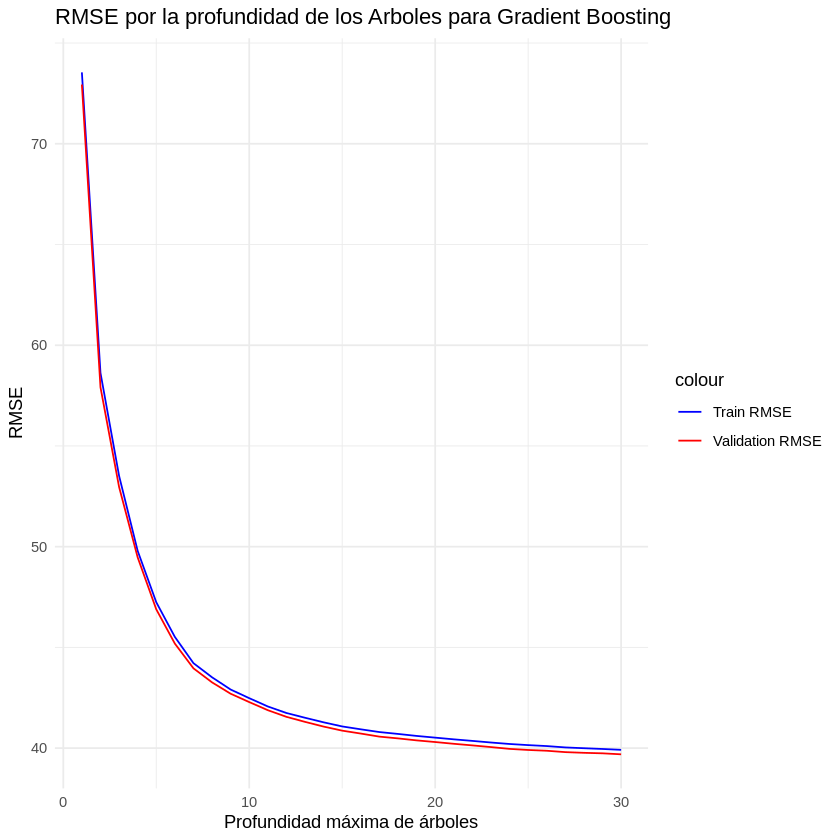

In [ ]:
ggplot(df_metricas, aes(x = max_depth)) +
    geom_line(aes(y = train_rmse, color = "Train RMSE")) +
    geom_line(aes(y = val_rmse, color = "Validation RMSE")) +
    labs(title = "RMSE por la profundidad de los Arboles para Gradient Boosting",
         x = "Profundidad máxima de árboles",
         y = "RMSE") +
    scale_color_manual(values = c("Train RMSE" = "blue", "Validation RMSE" = "red")) +
    theme_minimal()

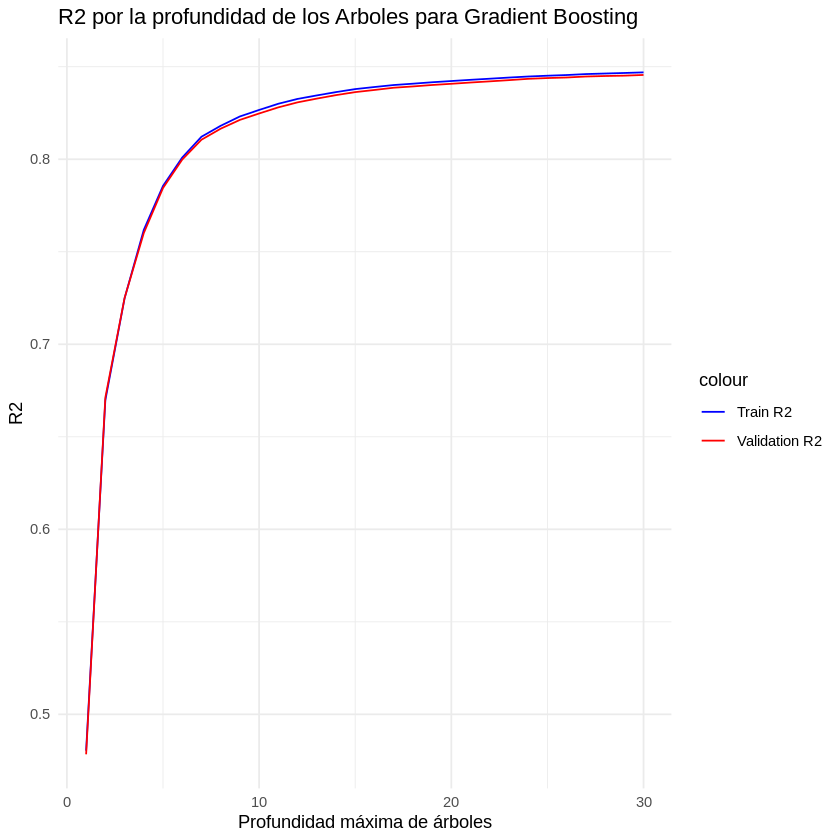

In [ ]:
ggplot(df_metricas, aes(x = max_depth)) +
    geom_line(aes(y = train_r2, color = "Train R2")) +
    geom_line(aes(y = val_r2, color = "Validation R2")) +
    labs(title = "R2 por la profundidad de los Arboles para Gradient Boosting",
         x = "Profundidad máxima de árboles",
         y = "R2") +
    scale_color_manual(values = c("Train R2" = "blue", "Validation R2" = "red")) +
    theme_minimal()

Entrenamos el modelo con valor optimo de max_depth = 7 para diferentes valores dl numero de árboles (n_estimators)

In [ ]:
learning_rate <-  0.01
max_depth <- 7

n_estimators_list <- c()
train_rmse_list <- c()
train_mae_list <- c()
train_r2_list <- c()
val_rmse_list <-c()
val_mae_list <- c()
val_r2_list <- c()
i <- 1

for (n_estimators in seq(100, 2000, by=100)) {
 cat("\nEl numero árboles: ", n_estimators, "\n")
 start_time <- Sys.time()
 model_gbm = gbm(downtime_gross ~ waiting_hours + changed_pcs + mechanic + action_desc +
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost +
    Cumulative_Failure_Count, data = train_data5,
                 distribution = "gaussian",
                # cv.folds = 10,
                 shrinkage = learning_rate,
                 n.trees = n_estimators,
                 interaction.depth = max_depth)
 end_time <- Sys.time()
 training_time8 <- end_time - start_time
 cat("Training time: ", training_time8, "\n")

 # Predecir con el conjunto de entrenamiento
 train_predictions <- predict(model_gbm, newdata = train_data5)

 # Calcular métricas de rendimiento para el conjunto de entrenamiento
 train_actuals <- train_data5$downtime_gross
 train_rmse <- sqrt(mean((train_predictions - train_actuals)^2))
 train_mae <- mean(abs(train_predictions - train_actuals))
 train_r2 <- 1 - (sum((train_predictions - train_actuals)^2) / sum((train_actuals - mean(train_actuals))^2))

 cat("Train RMSE: ", train_rmse, "\n")
 cat("Train MAE: ", train_mae, "\n")
 cat("Train R-squared: ", train_r2, "\n\n")

 # Predecir con el conjunto de validación
 validation_predictions <- predict(model_gbm, newdata = validation_data5)

 # Calcular métricas de rendimiento para el conjunto de validación
 validation_actuals <- validation_data5$downtime_gross
 validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
 validation_mae <- mean(abs(validation_predictions - validation_actuals))
 validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

 cat("Validation RMSE: ", validation_rmse, "\n")
 cat("Validation MAE: ", validation_mae, "\n")
 cat("Validation R-squared: ", validation_r2, "\n")

 n_estimators_list[i] <- n_estimators
 train_rmse_list[i] <- train_rmse
 train_mae_list[i] <- train_mae
 train_r2_list[i] <- train_r2
 val_rmse_list[i] <-validation_rmse
 val_mae_list[i] <- validation_mae
 val_r2_list[i] <- validation_r2
 i <- i + 1

}

df_metricas <- data.frame(n_estimators_list, train_rmse_list, train_mae_list, train_r2_list, val_rmse_list,val_mae_list, val_r2_list)
colnames(df_metricas) <- c("n_estimators", "train_rmse", "train_mae", "train_r2", "val_rmse", "val_mae", "val_r2")
df_metricas




El numero árboles:  100 
Training time:  12.85801 


Using 100 trees...




Train RMSE:  44.2382 
Train MAE:  30.24379 
Train R-squared:  0.8119792 



Using 100 trees...




Validation RMSE:  43.98359 
Validation MAE:  30.03848 
Validation R-squared:  0.8103409 

El numero árboles:  200 
Training time:  25.75138 


Using 200 trees...




Train RMSE:  23.1714 
Train MAE:  16.73727 
Train R-squared:  0.9484159 



Using 200 trees...




Validation RMSE:  23.1207 
Validation MAE:  16.65227 
Validation R-squared:  0.9475924 

El numero árboles:  300 
Training time:  37.71083 


Using 300 trees...




Train RMSE:  16.1042 
Train MAE:  12.20196 
Train R-squared:  0.9750834 



Using 300 trees...




Validation RMSE:  16.06335 
Validation MAE:  12.18208 
Validation R-squared:  0.9747033 

El numero árboles:  400 
Training time:  50.33917 


Using 400 trees...




Train RMSE:  13.9917 
Train MAE:  10.8822 
Train R-squared:  0.9811916 



Using 400 trees...




Validation RMSE:  13.96123 
Validation MAE:  10.89667 
Validation R-squared:  0.9808909 

El numero árboles:  500 
Training time:  1.048639 


Using 500 trees...




Train RMSE:  13.37167 
Train MAE:  10.51371 
Train R-squared:  0.9828216 



Using 500 trees...




Validation RMSE:  13.34482 
Validation MAE:  10.52308 
Validation R-squared:  0.9825411 

El numero árboles:  600 
Training time:  1.268269 


Using 600 trees...




Train RMSE:  13.15259 
Train MAE:  10.40457 
Train R-squared:  0.9833799 



Using 600 trees...




Validation RMSE:  13.13521 
Validation MAE:  10.41769 
Validation R-squared:  0.9830852 

El numero árboles:  700 
Training time:  1.483623 


Using 700 trees...




Train RMSE:  13.0524 
Train MAE:  10.33993 
Train R-squared:  0.9836321 



Using 700 trees...




Validation RMSE:  13.04364 
Validation MAE:  10.35453 
Validation R-squared:  0.9833202 

El numero árboles:  800 
Training time:  1.689365 


Using 800 trees...




Train RMSE:  12.98983 
Train MAE:  10.29775 
Train R-squared:  0.9837887 



Using 800 trees...




Validation RMSE:  12.99212 
Validation MAE:  10.32033 
Validation R-squared:  0.9834517 

El numero árboles:  900 
Training time:  1.88883 


Using 900 trees...




Train RMSE:  12.97407 
Train MAE:  10.28059 
Train R-squared:  0.983828 



Using 900 trees...




Validation RMSE:  12.97885 
Validation MAE:  10.3024 
Validation R-squared:  0.9834855 

El numero árboles:  1000 
Training time:  2.119235 


Using 1000 trees...




Train RMSE:  12.93282 
Train MAE:  10.25203 
Train R-squared:  0.9839307 



Using 1000 trees...




Validation RMSE:  12.95185 
Validation MAE:  10.2828 
Validation R-squared:  0.9835542 

El numero árboles:  1100 
Training time:  2.302208 


Using 1100 trees...




Train RMSE:  12.90746 
Train MAE:  10.23017 
Train R-squared:  0.9839936 



Using 1100 trees...




Validation RMSE:  12.92517 
Validation MAE:  10.258 
Validation R-squared:  0.9836219 

El numero árboles:  1200 
Training time:  2.518917 


Using 1200 trees...




Train RMSE:  12.88734 
Train MAE:  10.21496 
Train R-squared:  0.9840435 



Using 1200 trees...




Validation RMSE:  12.91225 
Validation MAE:  10.24852 
Validation R-squared:  0.9836546 

El numero árboles:  1300 
Training time:  2.685107 


Using 1300 trees...




Train RMSE:  12.8617 
Train MAE:  10.19858 
Train R-squared:  0.9841069 



Using 1300 trees...




Validation RMSE:  12.89658 
Validation MAE:  10.23704 
Validation R-squared:  0.9836942 

El numero árboles:  1400 
Training time:  2.914168 


Using 1400 trees...




Train RMSE:  12.83549 
Train MAE:  10.17897 
Train R-squared:  0.9841716 



Using 1400 trees...




Validation RMSE:  12.87724 
Validation MAE:  10.22167 
Validation R-squared:  0.9837431 

El numero árboles:  1500 
Training time:  3.058414 


Using 1500 trees...




Train RMSE:  12.81334 
Train MAE:  10.16278 
Train R-squared:  0.9842262 



Using 1500 trees...




Validation RMSE:  12.86134 
Validation MAE:  10.20997 
Validation R-squared:  0.9837832 

El numero árboles:  1600 
Training time:  3.269619 


Using 1600 trees...




Train RMSE:  12.79608 
Train MAE:  10.15153 
Train R-squared:  0.9842687 



Using 1600 trees...




Validation RMSE:  12.84671 
Validation MAE:  10.20173 
Validation R-squared:  0.9838201 

El numero árboles:  1700 
Training time:  3.427627 


Using 1700 trees...




Train RMSE:  12.77033 
Train MAE:  10.12967 
Train R-squared:  0.9843319 



Using 1700 trees...




Validation RMSE:  12.83003 
Validation MAE:  10.18959 
Validation R-squared:  0.9838621 

El numero árboles:  1800 
Training time:  3.641231 


Using 1800 trees...




Train RMSE:  12.76498 
Train MAE:  10.12508 
Train R-squared:  0.9843451 



Using 1800 trees...




Validation RMSE:  12.82364 
Validation MAE:  10.18031 
Validation R-squared:  0.9838782 

El numero árboles:  1900 
Training time:  3.863667 


Using 1900 trees...




Train RMSE:  12.74796 
Train MAE:  10.1107 
Train R-squared:  0.9843868 



Using 1900 trees...




Validation RMSE:  12.81909 
Validation MAE:  10.17212 
Validation R-squared:  0.9838896 

El numero árboles:  2000 
Training time:  4.064318 


Using 2000 trees...




Train RMSE:  12.73307 
Train MAE:  10.09972 
Train R-squared:  0.9844232 



Using 2000 trees...




Validation RMSE:  12.80881 
Validation MAE:  10.16548 
Validation R-squared:  0.9839154 


n_estimators,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,44.23820,30.24379,0.8119792,43.98359,30.03848,0.8103409
200,23.17140,16.73727,0.9484159,23.12070,16.65227,0.9475924
300,16.10420,12.20196,0.9750834,16.06335,12.18208,0.9747033
400,13.99170,10.88220,0.9811916,13.96123,10.89667,0.9808909
500,13.37167,10.51371,0.9828216,13.34482,10.52308,0.9825411
600,13.15259,10.40457,0.9833799,13.13521,10.41769,0.9830852
700,13.05240,10.33993,0.9836321,13.04364,10.35453,0.9833202
800,12.98983,10.29775,0.9837887,12.99212,10.32033,0.9834517
900,12.97407,10.28059,0.9838280,12.97885,10.30240,0.9834855


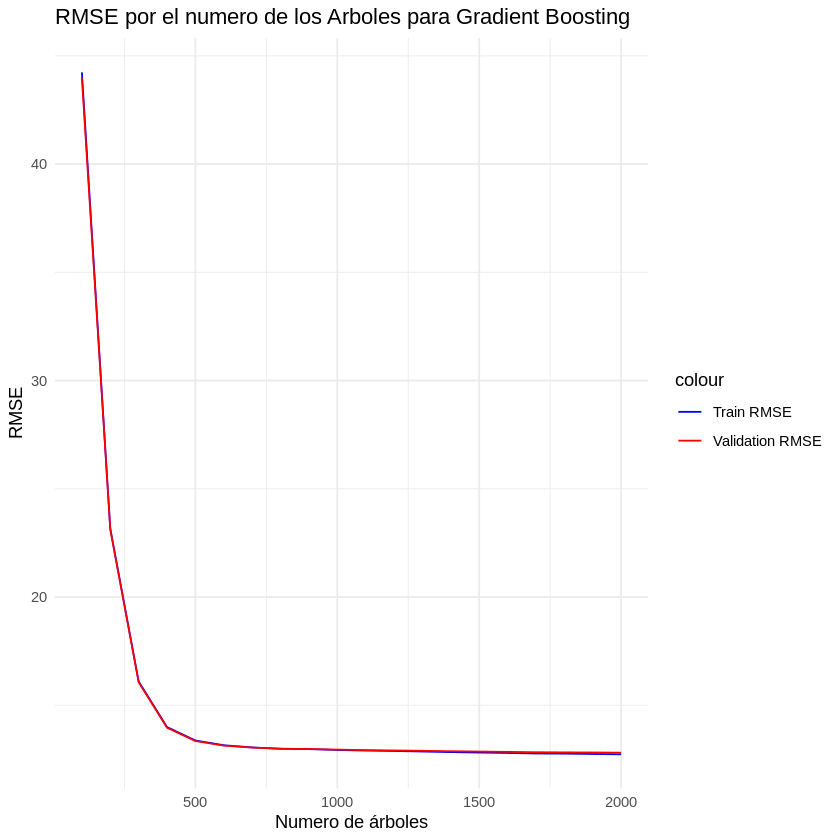

In [ ]:
ggplot(df_metricas, aes(x = n_estimators)) +
    geom_line(aes(y = train_rmse, color = "Train RMSE")) +
    geom_line(aes(y = val_rmse, color = "Validation RMSE")) +
    labs(title = "RMSE por el numero de los Arboles para Gradient Boosting",
         x = "Numero de árboles",
         y = "RMSE") +
    scale_color_manual(values = c("Train RMSE" = "blue", "Validation RMSE" = "red")) +
    theme_minimal()

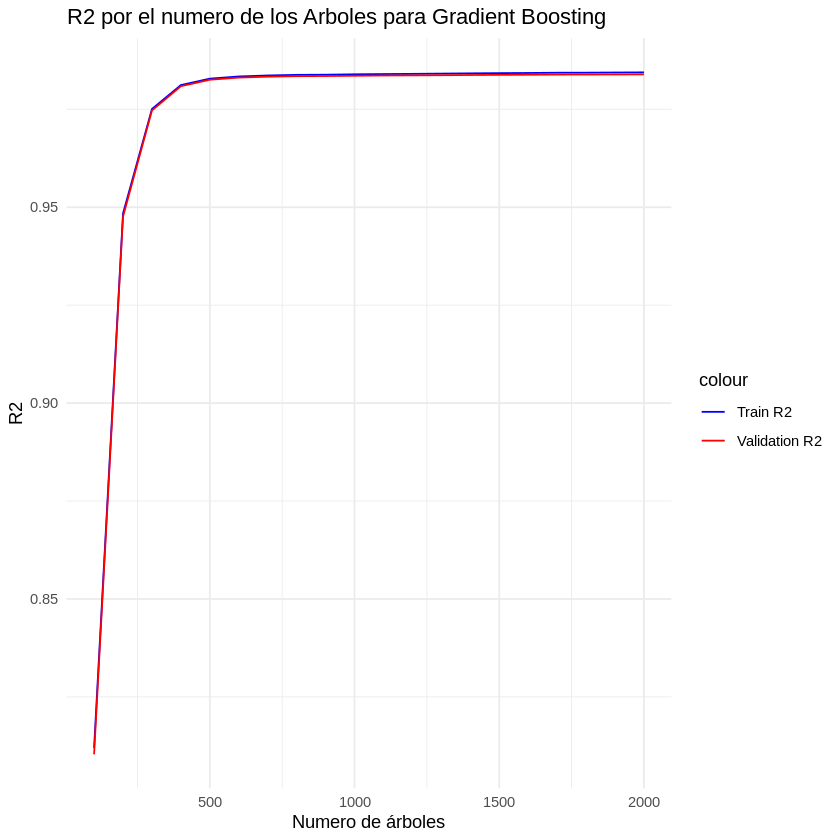

In [ ]:
ggplot(df_metricas, aes(x = n_estimators)) +
    geom_line(aes(y = train_r2, color = "Train R2")) +
    geom_line(aes(y = val_r2, color = "Validation R2")) +
    labs(title = "R2 por el numero de los Arboles para Gradient Boosting",
         x = "Numero de árboles",
         y = "R2") +
    scale_color_manual(values = c("Train R2" = "blue", "Validation R2" = "red")) +
    theme_minimal()

In [ ]:
df_metricas[df_metricas$n_estimators==500,]

,n_estimators,train_rmse,train_mae,train_r2,val_rmse,val_mae,val_r2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,500,13.37167,10.51371,0.9828216,13.34482,10.52308,0.9825411


Entrenamos el modelo optimal con max_depth = 7 y n_estimators = 500

In [ ]:
formula

downtime_gross ~ waiting_hours + changed_pcs + mechanic + action_desc + 
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost + 
    Cumulative_Failure_Count

In [ ]:
learning_rate <-  0.01
max_depth <- 7
n_estimators <- 500

start_time <- Sys.time()
model_gbm = gbm(formula=formula, data = train_data5,
                 distribution = "gaussian",
                 #cv.folds = 10,
                 shrinkage = learning_rate,
                 n.trees = n_estimators,
                 interaction.depth = max_depth)
end_time <- Sys.time()
training_time8 <- end_time - start_time
cat("Training time: ", training_time8, "\n")

# Predecir con el conjunto de entrenamiento
train_predictions <- predict(model_gbm, newdata = train_data5)

# Calcular métricas de rendimiento para el conjunto de entrenamiento
train_actuals <- train_data5$downtime_gross
train_rmse <- sqrt(mean((train_predictions - train_actuals)^2))
train_mae <- mean(abs(train_predictions - train_actuals))
train_r2 <- 1 - (sum((train_predictions - train_actuals)^2) / sum((train_actuals - mean(train_actuals))^2))

cat("Train RMSE: ", train_rmse, "\n")
cat("Train MAE: ", train_mae, "\n")
cat("Train R-squared: ", train_r2, "\n\n")

# Predecir con el conjunto de validación
test_predictions <- predict(model_gbm, newdata = test_data5)

# Calcular métricas de rendimiento para el conjunto de validación
test_actuals <- test_data5$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Training time:  1.617319 


Using 500 trees...




Train RMSE:  13.35294 
Train MAE:  10.5075 
Train R-squared:  0.9828697 



Using 500 trees...




Test RMSE:  13.33763 
Test MAE:  10.46641 
Test R-squared:  0.9827501 


# **MODELO RED NEURAL**

In [ ]:
install.packages("tensorflow")
library(tensorflow)
install.packages("keras3")
library(keras3)
install.packages("tidyverse")
library(tidyverse)
install.packages("tidymodels")
library(tidymodels)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘reticulate’, ‘tfruns’, ‘tfautograph’



Attaching package: ‘tensorflow’


The following object is masked from ‘package:caret’:

    train


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’



Attaching package: ‘keras3’


The following objects are masked from ‘package:tensorflow’:

    set_random_seed, shape


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.1
✔ stringr 1.5.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ scales::col_factor()    masks readr::col_factor()
✖ randomForest::combine() masks dplyr::combine()
✖ purrr::discard()  

In [ ]:
dim(train_data4)
dim(validation_data4)
dim(test_data4)

[1] 95100    18

[1] 27171    18

[1] 13587    18

In [ ]:
formula

downtime_gross ~ waiting_hours + changed_pcs + mechanic + action_desc + 
    parts_cost + base_model + cause_desc + failure_desc + Cumulative_Maintenance_Cost + 
    Cumulative_Failure_Count

**Creamos el conjunto de datos del entrenamiento y de la evaluación**

In [ ]:
encoder1 <- LabelEncoder$new()
encoder2 <- LabelEncoder$new()
encoder3 <- LabelEncoder$new()
encoder4 <- LabelEncoder$new()
encoder5 <- LabelEncoder$new()
encoder6 <- LabelEncoder$new()
encoder7 <- LabelEncoder$new()

data_for_rn <- rbind(rbind(train_data4, validation_data4), test_data4)

data_for_rn$operation <- encoder1$fit_transform(data_for_rn$operation)
data_for_rn$base_model <- encoder2$fit_transform(data_for_rn$base_model)
data_for_rn$problem_desc <- encoder3$fit_transform(data_for_rn$problem_desc)
data_for_rn$failure_desc <- encoder4$fit_transform(data_for_rn$failure_desc)
data_for_rn$cause_desc <- encoder5$fit_transform(data_for_rn$cause_desc)
data_for_rn$action_desc <- encoder6$fit_transform(data_for_rn$action_desc)
data_for_rn$mechanic <- encoder7$fit_transform(data_for_rn$mechanic)

data_for_rn <- data_for_rn[, c("waiting_hours", "changed_pcs", "mechanic", "action_desc",
                               "parts_cost", "base_model", "cause_desc", "failure_desc",
                               "Cumulative_Maintenance_Cost", "Cumulative_Failure_Count",
                               "downtime_gross")]
head(data_for_rn, 6)


waiting_hours,changed_pcs,mechanic,action_desc,parts_cost,base_model,cause_desc,failure_desc,Cumulative_Maintenance_Cost,Cumulative_Failure_Count,downtime_gross
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.6666667,0,0,0,0.00,0,0,0,75.32,8,65
0.0000000,1,1,1,0.00,1,1,1,13.30,9,30
0.0000000,0,2,2,73.48,2,2,1,1035.76,41,15
0.0000000,0,0,2,0.00,1,1,0,707.77,27,25
1.5000000,0,3,3,0.00,0,2,2,149.30,25,115
0.1666667,0,4,0,0.00,3,3,2,42.40,24,15


In [ ]:
summary(data_for_rn)

 waiting_hours      changed_pcs        mechanic      action_desc    
 Min.   :-4.0000   Min.   : 0.000   Min.   : 0.00   Min.   : 0.000  
 1st Qu.: 0.0000   1st Qu.: 0.000   1st Qu.: 7.00   1st Qu.: 2.000  
 Median : 0.0000   Median : 1.000   Median :28.00   Median : 6.000  
 Mean   : 0.4955   Mean   : 0.999   Mean   :33.12   Mean   : 8.028  
 3rd Qu.: 0.3333   3rd Qu.: 1.000   3rd Qu.:54.00   3rd Qu.:12.000  
 Max.   :10.0000   Max.   :14.000   Max.   :85.00   Max.   :28.000  
   parts_cost        base_model       cause_desc      failure_desc  
 Min.   :   0.00   Min.   : 0.000   Min.   : 0.000   Min.   :0.000  
 1st Qu.:   0.00   1st Qu.: 1.000   1st Qu.: 2.000   1st Qu.:0.000  
 Median :   0.00   Median : 7.000   Median : 5.000   Median :2.000  
 Mean   :  12.11   Mean   : 6.874   Mean   : 7.908   Mean   :1.402  
 3rd Qu.:   6.00   3rd Qu.:12.000   3rd Qu.:10.000   3rd Qu.:2.000  
 Max.   :2812.49   Max.   :21.000   Max.   :28.000   Max.   :3.000  
 Cumulative_Maintenance_Cost Cumul

In [ ]:
# Cambiamos los valores NA de la variable Age por la mediana
#mediana_Age <- median(data_for_rn$Age, na.rm = TRUE)
#data_for_rn$Age[is.na(data_for_rn$Age)] <- mediana_Age
#summary(data_for_rn$Age)

In [ ]:
# Crear conjuntos de entrenamiento y de prueba para el modelo Red Neural

train_data6 <- data_for_rn[1:(nrow(train_data4) + nrow(validation_data4)),]
test_data6 <- data_for_rn[(nrow(train_data4) + nrow(validation_data4)+1):(nrow(train_data4) + nrow(validation_data4)+nrow(test_data4)),]

dim(train_data6)
dim(test_data6)

[1] 122271     11

[1] 13587    11

In [ ]:
# Dividimos datasets por características y etiquetas para entrenar luego el modelo

X_train <- as.matrix(select(train_data6, -downtime_gross))
Y_train <- as.matrix(select(train_data6, downtime_gross))

X_test <- as.matrix(select(test_data6, -downtime_gross))
Y_test <- as.matrix(select(test_data6, downtime_gross))

print("Dimenciones del conjunto de datos de entrenamiento: ")
dim(X_train)
dim(Y_train)

print("Dimenciones del conjunto de datos de prueba: ")
dim(X_test)
dim(Y_test)

[1] "Dimenciones del conjunto de datos de entrenamiento: "


[1] 122271     10

[1] 122271      1

[1] "Dimenciones del conjunto de datos de prueba: "


[1] 13587    10

[1] 13587     1

**Creamos el modelo optimo**

In [ ]:
normalizer <- layer_normalization(axis = -1L)
normalizer %>% adapt(X_train)

In [ ]:
print(normalizer$mean)

tf.Tensor(
[[  0.49508613   1.0002536   33.12217      8.02187     12.14835
    6.864023     7.900524     1.4026793  428.62332     35.278625  ]], shape=(1, 10), dtype=float32)


Dos capas leneales, epochs = 30

In [ ]:
model_rn_optimo <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn_optimo %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn_optimo)

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense (Dense)                 │ (None, 64)             │         704 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_1 (Dense)               │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_2 (Dense)               │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 4,950 (19.34 KB)
 Trainable params: 4,929 (19.25 KB)
 Non-trainable params

In [ ]:
history <- model_rn_optimo %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 30)

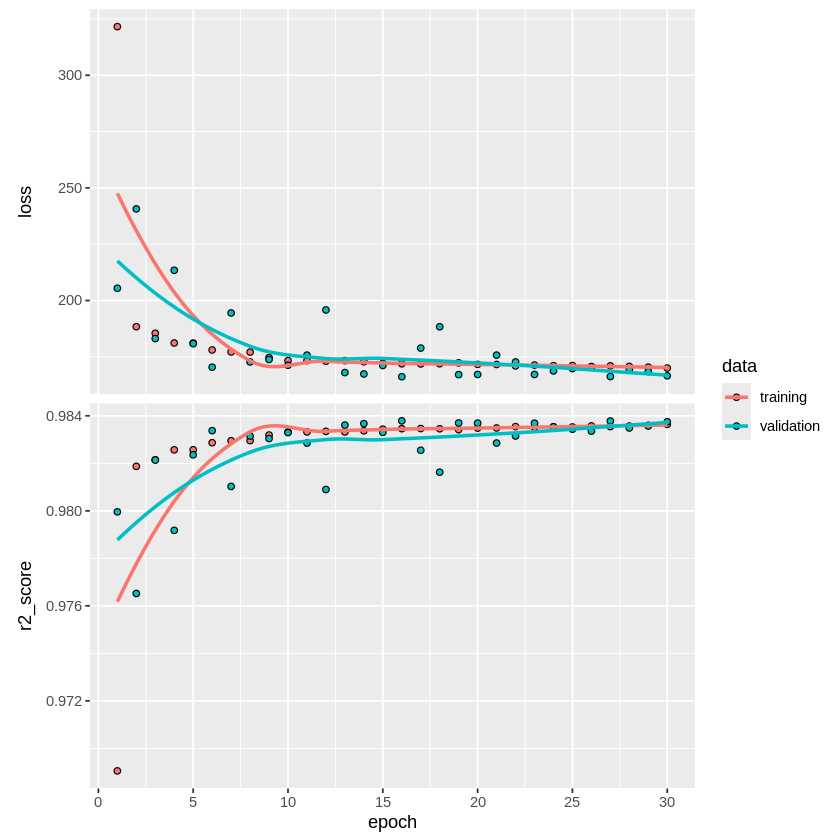

In [ ]:
plot(history)

In [ ]:
history


Final epoch (plot to see history):
        loss: 170
    r2_score: 0.9836
    val_loss: 166.6
val_r2_score: 0.9837 

In [ ]:
# Predecir con el conjunto de entrenamiento
train_predictions <- predict(model_rn_optimo, X_train)

# Calcular métricas de rendimiento para el conjunto de entrenamiento
train_actuals <- Y_train #train_data6$downtime_gross
train_rmse <- sqrt(mean((train_predictions - train_actuals)^2))
train_mae <- mean(abs(train_predictions - train_actuals))
train_r2 <- 1 - (sum((train_predictions - train_actuals)^2) / sum((train_actuals - mean(train_actuals))^2))

cat("Train RMSE: ", train_rmse, "\n")
cat("Train MAE: ", train_mae, "\n")
cat("Train R-squared: ", train_r2, "\n\n")

# Predecir con el conjunto de validación
test_predictions <- predict(model_rn_optimo, X_test)

# Calcular métricas de rendimiento para el conjunto de validación
test_actuals <- Y_test #test_data6$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Train RMSE:  12.90847 
Train MAE:  10.20195 
Train R-squared:  0.9839197 

Test RMSE:  12.77814 
Test MAE:  10.09317 
Test R-squared:  0.984167 


**Pruebas de modelos con parametros diferentes**

Dos capas lineales, epochs = 100, loss = mean_squared_error, learning_rate = 0.01

In [ ]:
model_rn <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn)

Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_6 (Dense)               │ (None, 64)             │         704 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_7 (Dense)               │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_8 (Dense)               │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 4,950 (19.34 KB)
 Trainable params: 4,929 (19.25 KB)
 Non-trainable para

In [ ]:
history <- model_rn %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 100)

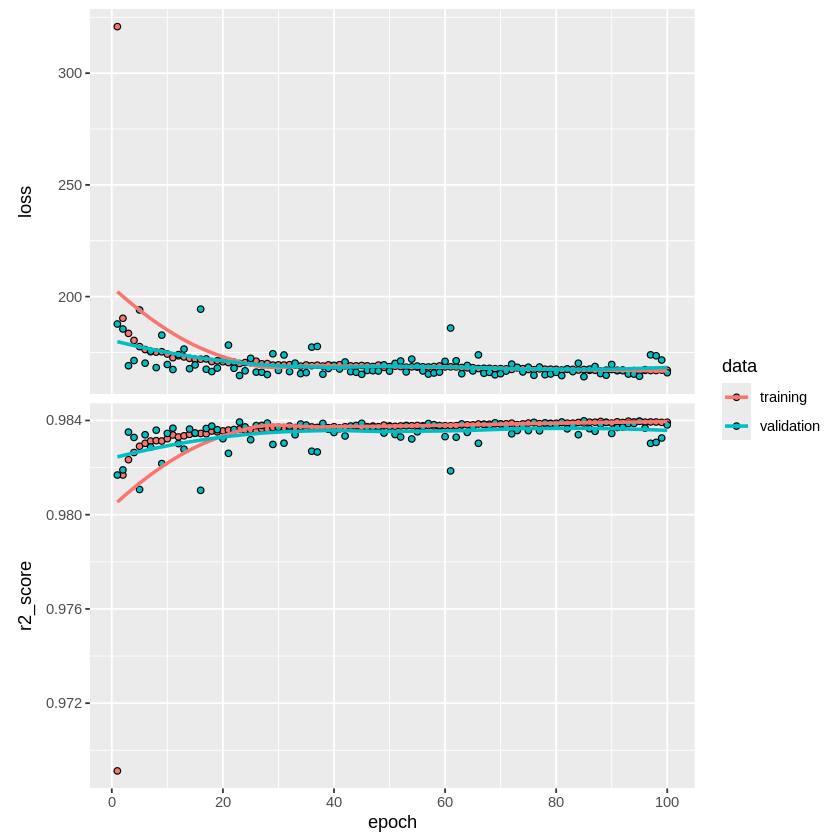

In [ ]:
plot(history)

In [ ]:
history


Final epoch (plot to see history):
        loss: 167
    r2_score: 0.9839
    val_loss: 165.9
val_r2_score: 0.9838 

Dos capas lineale, epochs = 30, loss = mean_absolute_error, learning_rate = 0.01

In [ ]:
model_rn1 <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn1 %>% compile(
    loss = 'mean_absolute_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn1)

Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_6 (Dense)               │ (None, 64)             │         704 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_7 (Dense)               │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_8 (Dense)               │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 4,950 (19.34 KB)
 Trainable params: 4,929 (19.25 KB)
 Non-trainable para

In [ ]:
history1 <- model_rn1 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 30)

In [ ]:
history1


Final epoch (plot to see history):
        loss: 10.11
    r2_score: 0.9827
    val_loss: 10.25
val_r2_score: 0.9819 

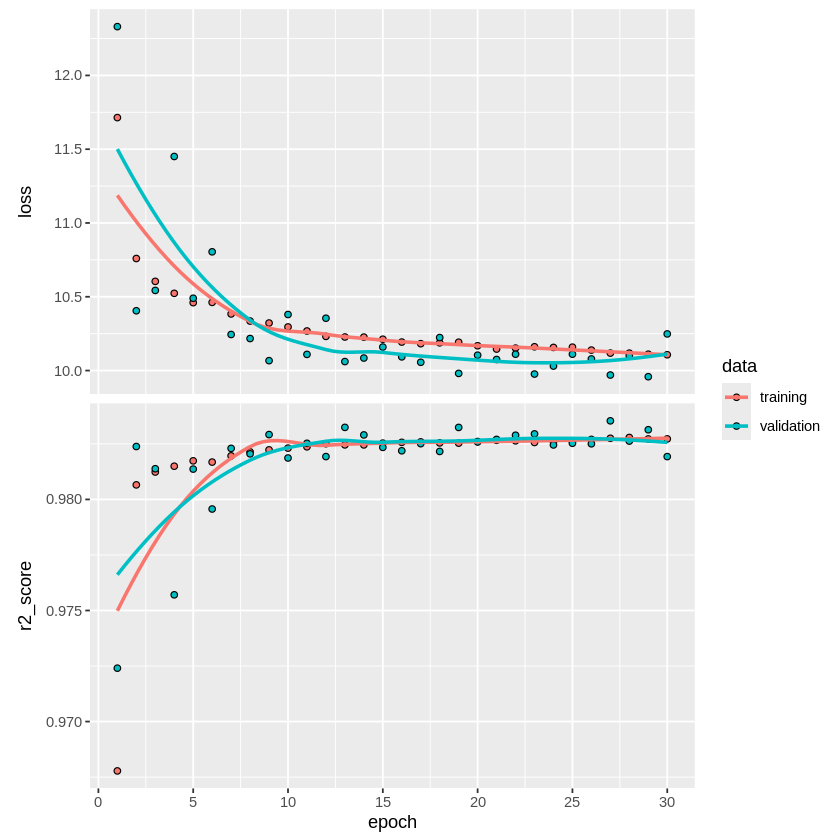

In [ ]:
plot(history1)

Una capa lineal, leraning_rate = 0.01

In [ ]:
model_rn2 <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(1)

model_rn2 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn2)

Model: "sequential_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_9 (Dense)               │ (None, 1)              │          11 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 32 (132.00 B)
 Trainable params: 11 (44.00 B)
 Non-trainable params: 21 (88.00 B)


In [ ]:
history2 <- model_rn2 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 30)


Final epoch (plot to see history):
        loss: 325.3
    r2_score: 0.9687
    val_loss: 328.1
val_r2_score: 0.968 

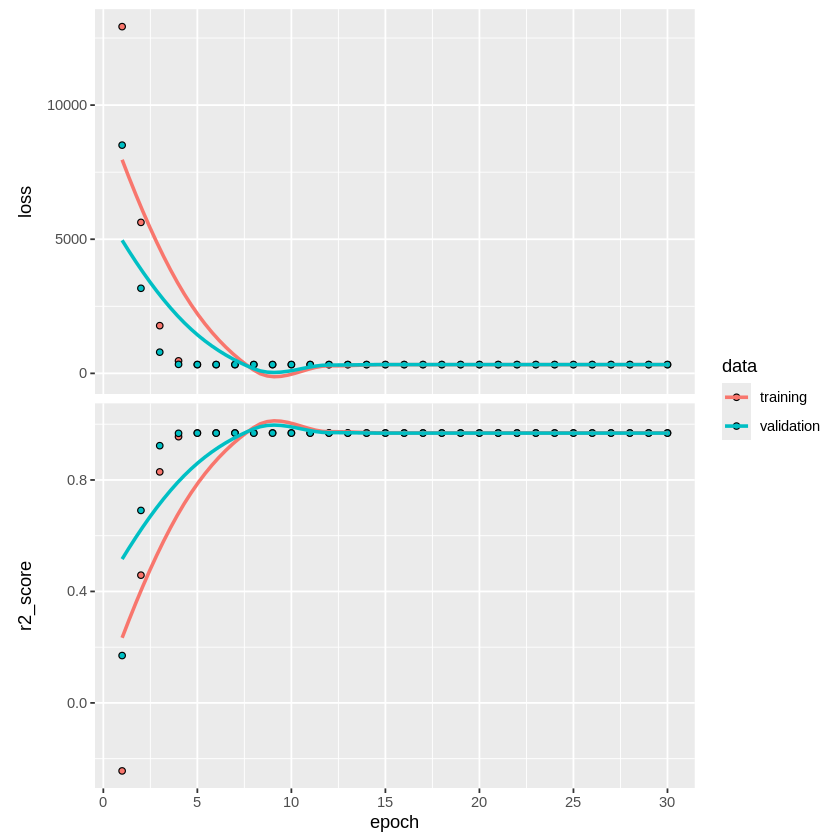

In [ ]:
plot(history2)
history2

Dos capas lineale, epochs = 30, loss = mean_squared_error, learning_rate = 0.001

In [ ]:
model_rn3 <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn3 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn3)

Model: "sequential_4"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_10 (Dense)              │ (None, 64)             │         704 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_11 (Dense)              │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_12 (Dense)              │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 4,950 (19.34 KB)
 Trainable params: 4,929 (19.25 KB)
 Non-trainable para


Final epoch (plot to see history):
        loss: 162.5
    r2_score: 0.9844
    val_loss: 165.9
val_r2_score: 0.9838 

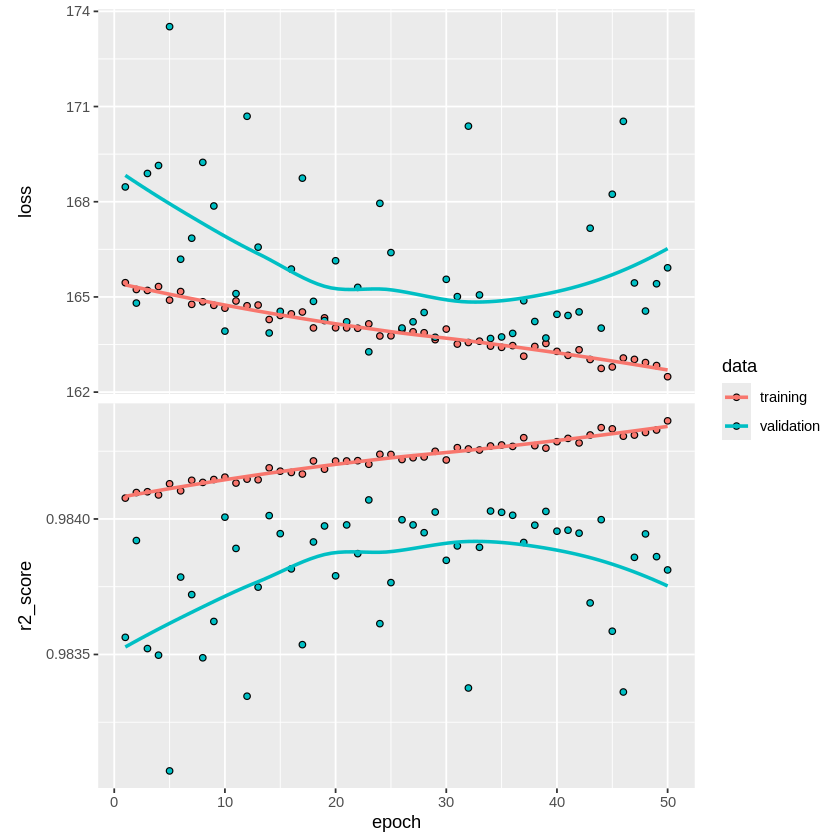

In [ ]:
history3 <- model_rn3 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 50)

plot(history3)
history3

Una capa lineal, loss = mean_absolute_error, learning_rate = 0.001

In [ ]:
model_rn4 <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(1)

model_rn4 %>% compile(
    loss = 'mean_absolute_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn4)

Model: "sequential_7"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_15 (Dense)              │ (None, 1)              │          11 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 32 (132.00 B)
 Trainable params: 11 (44.00 B)
 Non-trainable params: 21 (88.00 B)



Final epoch (plot to see history):
        loss: 14.43
    r2_score: 0.965
    val_loss: 14.46
val_r2_score: 0.9642 

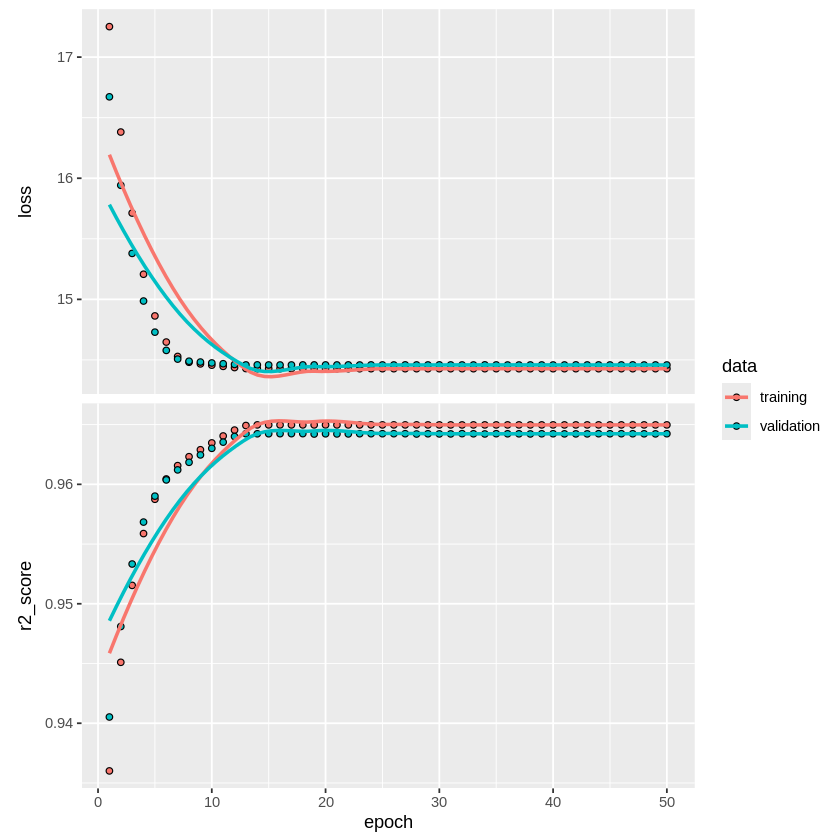

In [ ]:
history4 <- model_rn4 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 50)

plot(history4)
history4

Dos capas lineales, epochs = 30, loss = mean_squared_error, learning_rate = 0.001

In [ ]:
model_rn5 <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn5 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn5)

Model: "sequential_8"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_16 (Dense)              │ (None, 64)             │         704 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_17 (Dense)              │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_18 (Dense)              │ (None, 1)              │          65 │   Y   │
└───────────────────────────────┴────────────────────────┴─────────────┴───────┘
 Total params: 4,950 (19.34 KB)
 Trainable params: 4,929 (19.25 KB)
 Non-trainable para


Final epoch (plot to see history):
        loss: 162.8
    r2_score: 0.9843
    val_loss: 163.2
val_r2_score: 0.9841 

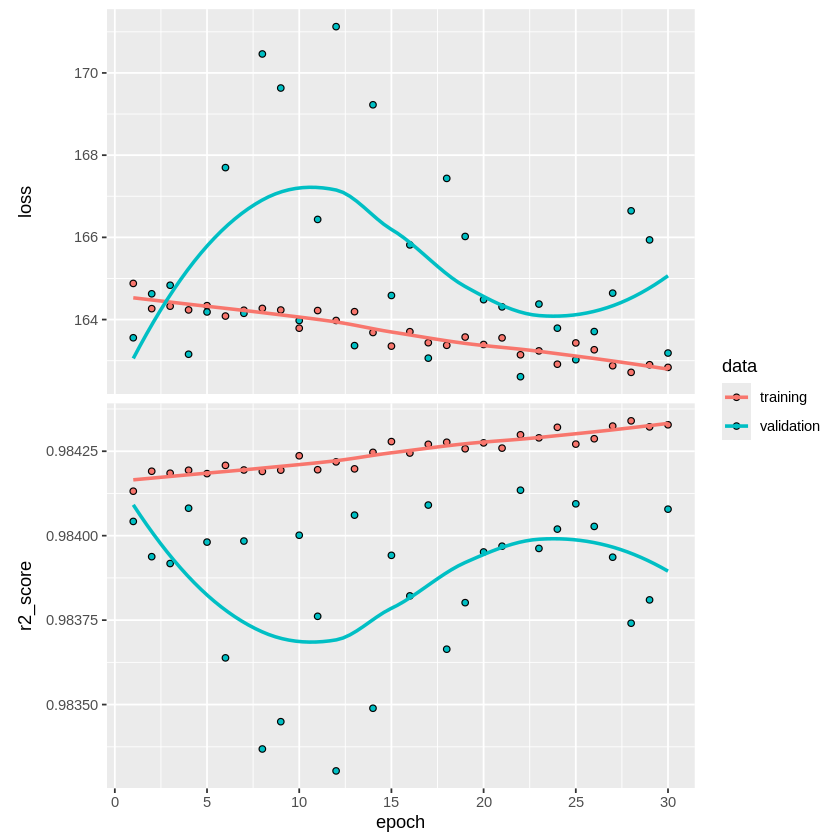

In [ ]:
history5 <- model_rn5 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 30)

  plot(history5)
  history5

Tres capas lineales, loss = mean_squared_error, learning_rate = 0.01, epoch = 30

In [ ]:
model_rn6 <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn6 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.01),
    metrics = "r2_score")

summary(model_rn6)

Model: "sequential_9"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_19 (Dense)              │ (None, 64)             │         704 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_20 (Dense)              │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_21 (Dense)              │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_22 (Dense)              │ (None, 1)              │          65 │   Y   │
└─────


Final epoch (plot to see history):
        loss: 171.7
    r2_score: 0.9835
    val_loss: 172.8
val_r2_score: 0.9831 

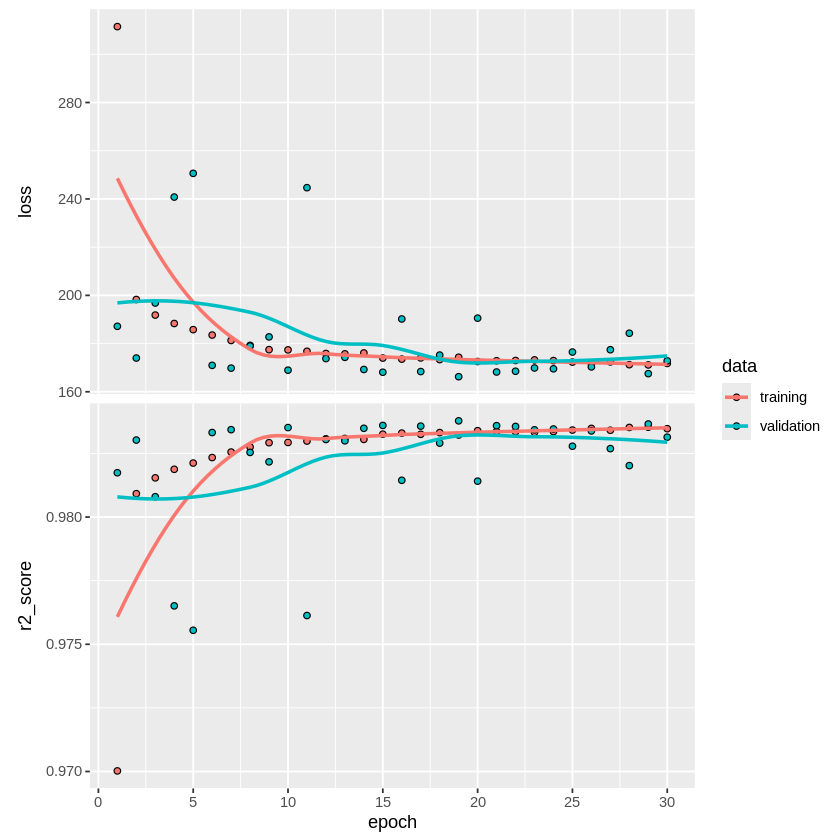

In [ ]:
history6 <- model_rn6 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.2,
  verbose = 2,
  epochs = 30)

  plot(history6)
  history6

Tres capas lineales, loss = mean_squared_error, learning_rate = 0.001, epoch = 30

In [ ]:
model_rn7 <- keras_model_sequential(shape=c(10)) %>%
    normalizer() %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(64, activation = 'relu') %>%
    layer_dense(1)

model_rn7 %>% compile(
    loss = 'mean_squared_error',
    optimizer = optimizer_adam(0.001),
    metrics = "r2_score")

summary(model_rn7)

Model: "sequential_12"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape           ┃     Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ normalization (Normalization) │ (None, 10)             │          21 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_31 (Dense)              │ (None, 64)             │         704 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_32 (Dense)              │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_33 (Dense)              │ (None, 64)             │       4,160 │   Y   │
├───────────────────────────────┼────────────────────────┼─────────────┼───────┤
│ dense_34 (Dense)              │ (None, 1)              │          65 │   Y   │
└────


Final epoch (plot to see history):
        loss: 166.5
    r2_score: 0.9841
    val_loss: 165
val_r2_score: 0.9837 

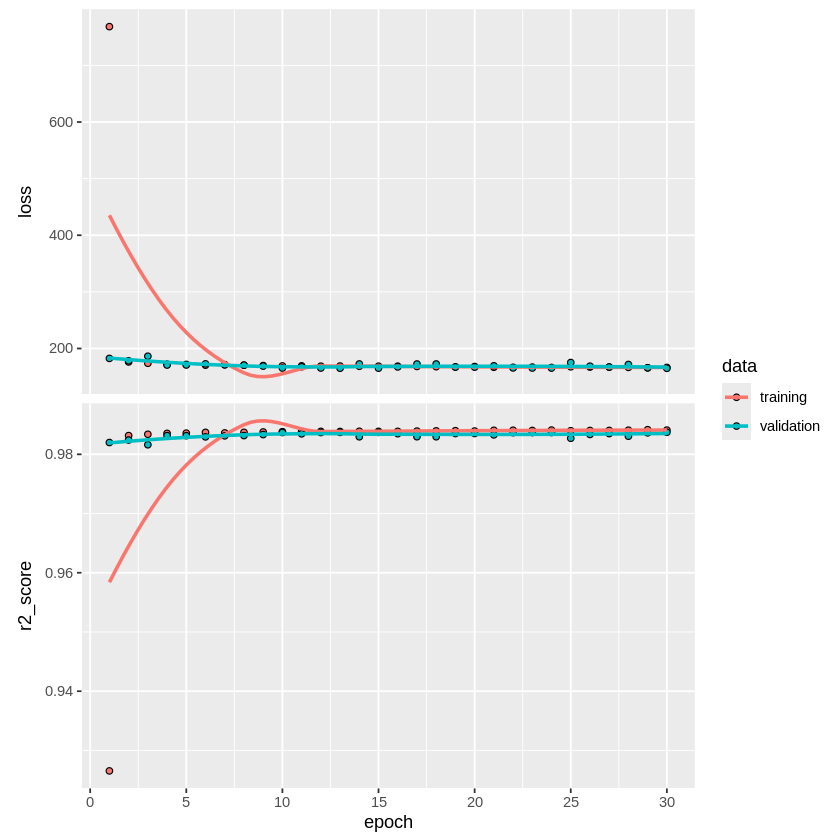

In [ ]:
history7 <- model_rn7 %>% fit(
  x = X_train,
  y = Y_train,
  validation_split = 0.3,
  verbose = 2,
  epochs = 30)

  plot(history7)
  history7